# CEG5103 Wireless and Sensor Networks for IoT / EE5024 IoT Sensor Networks

(c) CK Tham, ECE NUS, 2023

In [ ]:
# For Google Colab: can comment this out if file is already uploaded to Colab workspace
# Select and upload sensor_data.csv
import files   
uploaded = files.upload()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# For Google Colab: can comment this out if file is already uploaded to Colab workspace
# Select and upload fail_log.csv
from google.colab import files   
uploaded = files.upload()

#Failure Prediction

This notebook will guide you through building and comparing classification models for failure prediction. 

In [1]:
%matplotlib inline

# Import python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

## 1 Exploring the data

Let us begin by loading and exploring the sensor data.

In [2]:
file_path = 'sensor_data.csv'
sen_data = pd.read_csv(file_path)
print(sen_data.dtypes)
sen_data.head()

datetime      object
volt         float64
rotate       float64
pressure     float64
vibration    float64
dtype: object


datetime        volt      rotate    pressure  vibration
0  2015-01-01 06:00:00  151.919999  530.813578  101.788175  49.604013
1  2015-01-01 07:00:00  174.522001  535.523532  113.256009  41.515905
2  2015-01-01 08:00:00  146.912822  456.080746  107.786965  42.099694
3  2015-01-01 09:00:00  179.530561  503.469990  108.283817  37.847727
4  2015-01-01 10:00:00  180.544277  371.600611  107.553307  41.467880

The sensor data set consists of four different sensor measurements recorded at different time points. The `datetime` column needs to be converted to appropriate type.

In [3]:
print("-----BEFORE-----")
print(sen_data['datetime'][0])
print(type(sen_data['datetime'][0]))

# Date convert to timestamp data type
sen_data['datetime'] = pd.to_datetime(sen_data['datetime'])

print("-----AFTER-----")
print(sen_data['datetime'][0])
print(type(sen_data['datetime'][0]))

-----BEFORE-----
2015-01-01 06:00:00
<class 'str'>
-----AFTER-----
2015-01-01 06:00:00
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In addition, the failure log events are also available in `fail_log.csv`.

In [4]:
fail_dt = pd.read_csv('fail_log.csv')
fail_dt.head()

datetime
0   2/4/2015 6:00
1  3/21/2015 6:00
2   4/5/2015 6:00
3   5/5/2015 6:00
4  5/20/2015 6:00

The data consists of only a single column

In [5]:
fail_dt['datetime'] = pd.to_datetime(fail_dt['datetime']) # Date convert to timestamp data type

## 2 Visualizing the data

Let us visualize the voltage measurement along with the failure events.

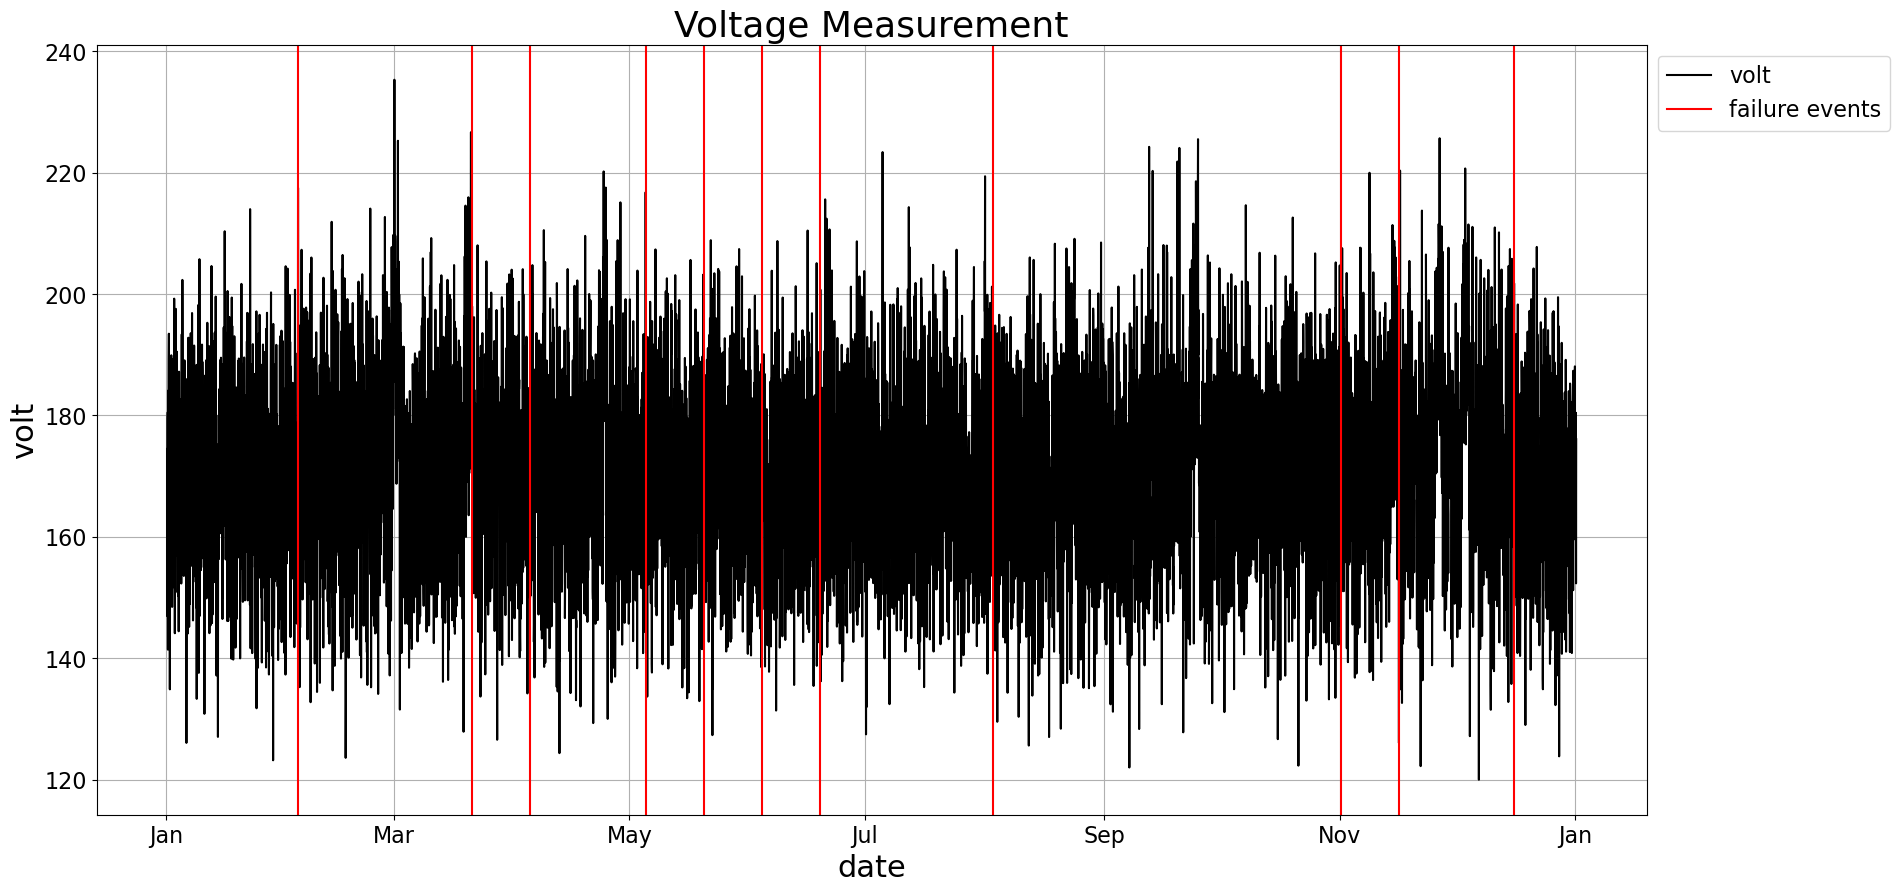

In [6]:
fig, ax =  plt.subplots(figsize=(20,10))

# Plot data
ax.plot(sen_data['datetime'], sen_data['volt'], color='black', label='volt') # plot sensor voltage data
ax.axvline(x=fail_dt['datetime'][0], color='red', label='failure events') # plot the 1st fail date data
for dt in fail_dt['datetime'][1:]: # plot remained fail date data 
  ax.axvline(x=dt, color='red') # plot seperately to avoid print labels repeatedly
"""
ax.axvline() is a matplotlib function that draws a vertical line at a specified x-axis position in a plot. 
It takes in one required argument x, which is the position on the x-axis where the line should be drawn, 
and a number of optional arguments such as color, linestyle, and linewidth to customize the appearance of 
the line.
"""

# Format X axis - DateTime
# date_form = DateFormatter("%m-%d")
date_form = DateFormatter("%b")
ax.xaxis.set_major_formatter(date_form)
"""
ax.xaxis.set_major_formatter(date_form) sets the major tick formatter for the x-axis of the plot to 
be the date_form object created above, which formats the tick labels as abbreviated month names.
"""

plt.title("Voltage Measurement", fontsize = 26)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlabel("date", fontsize = 22)
plt.ylabel("volt", fontsize = 22)
plt.grid()
plt.legend(fontsize = 16, bbox_to_anchor=(1, 1))

plt.show()

The plot represents the sensor measurements and the failure time points (red line).

A function to plot sensors and failure events in a single plot will be helpful later on.

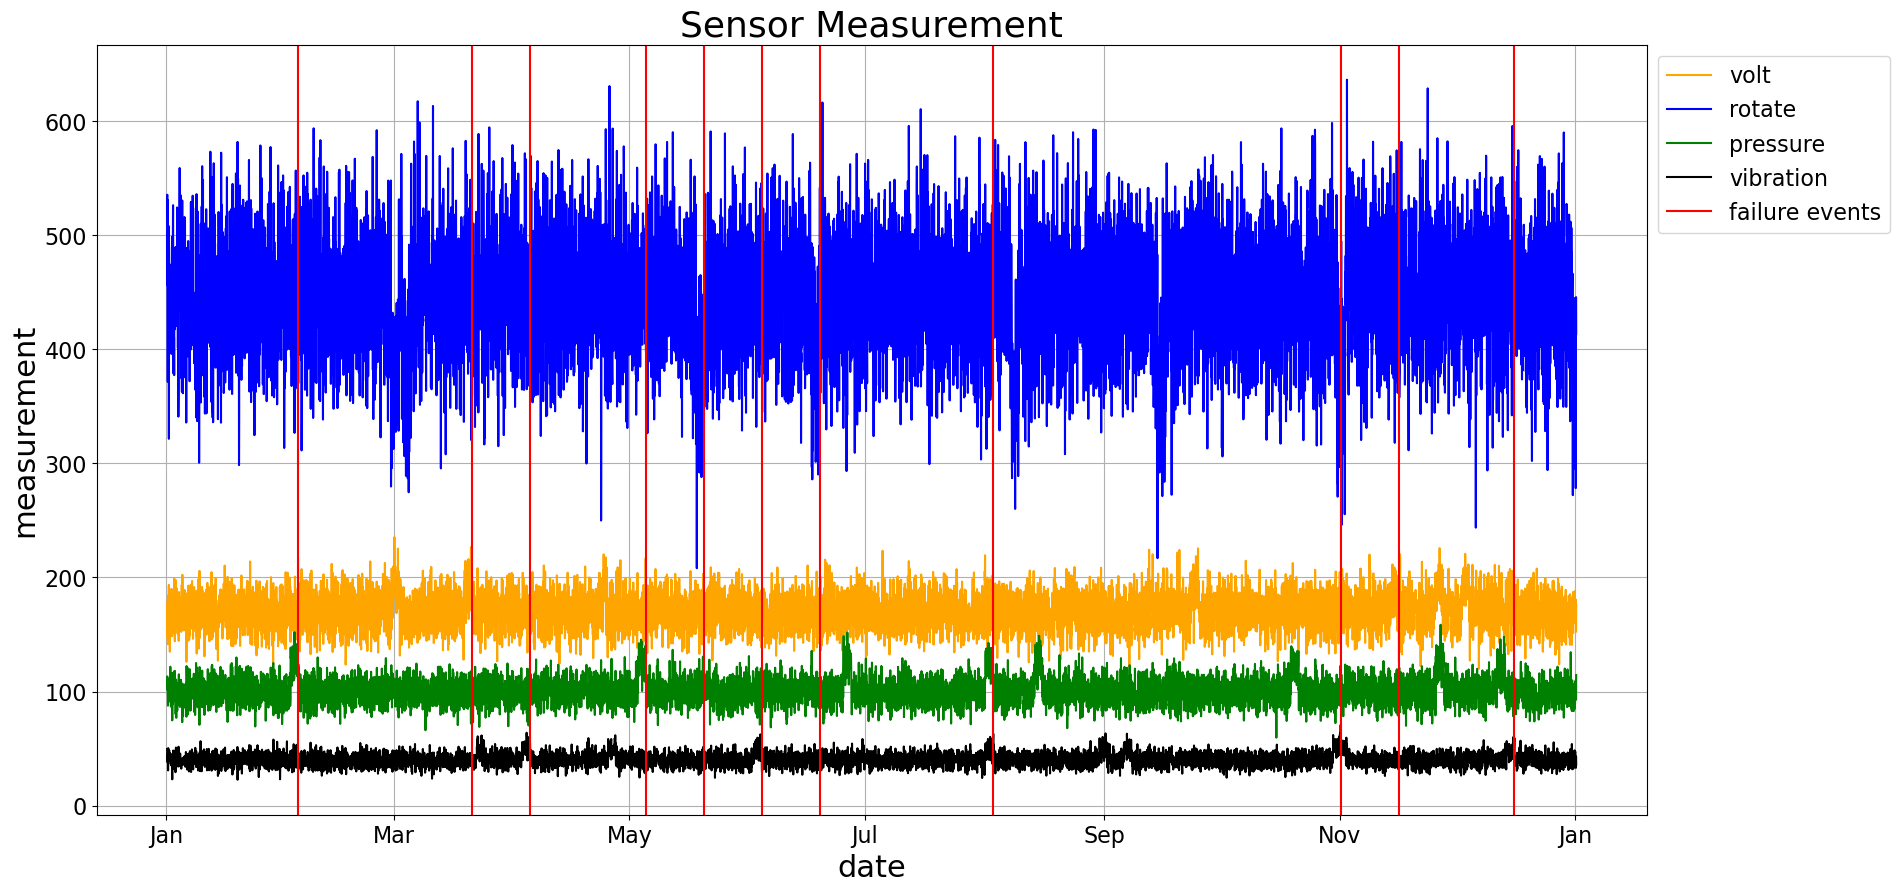

In [7]:
def plot_diagnostic_data(sen_data, fail_dt, predicted_fail_dt):
    """
    input: 
    sen_data: sensor data type: pandas.dataframe
    fail_dt: fail data type: pandas.dataframe.timestamp 
    predicted_fail_dt: predicted fail data type:pandas.dataframe
    """
    fig, ax =  plt.subplots(figsize=(20,10))

    # Plot data
    ax.plot(sen_data['datetime'], sen_data['volt'], color='orange', label='volt')
    ax.plot(sen_data['datetime'], sen_data['rotate'], color='blue', label='rotate')
    ax.plot(sen_data['datetime'], sen_data['pressure'], color='green', label='pressure')
    ax.plot(sen_data['datetime'], sen_data['vibration'], color='black', label='vibration')

    ax.axvline(x=fail_dt['datetime'][0], color='red', label='failure events')
    for dt in fail_dt['datetime'][1:]:
        ax.axvline(x=dt, color='red')

    if type(predicted_fail_dt) != type(None): # input existance detection
        if predicted_fail_dt.empty != True: # input dataframe empty detection
            ax.axvline(x=predicted_fail_dt['datetime'][0], color='blue', label='predicted failure events', linestyle = '--')
            for dt in predicted_fail_dt['datetime'][1:]:
                ax.axvline(x=dt, color='blue', linestyle = '--')
        else: 
            print('\033[91m' + '\033[1m' + '-'*50 + 'EMPTY PREDICTED FAILURE DATA!' + '-'*50 + '\033[0m')
            # error drop

    # Format X axis - DateTime
    # date_form = DateFormatter("%m-%d")
    date_form = DateFormatter("%b")
    ax.xaxis.set_major_formatter(date_form)

    plt.title("Sensor Measurement", fontsize = 26)
    plt.xticks(fontsize = 16)
    plt.yticks(fontsize = 16)
    plt.xlabel("date", fontsize = 22)
    plt.ylabel("measurement", fontsize = 22)
    plt.grid()
    plt.legend(fontsize = 16, bbox_to_anchor=(1, 1))

    plt.show()

plot_diagnostic_data(sen_data, fail_dt, None)

## 3 Sliding window

Sensor measurements are often noisy! Features from a sliding window are used to capture a better trend of the underlying data. Consider the voltage measurements in the month of February

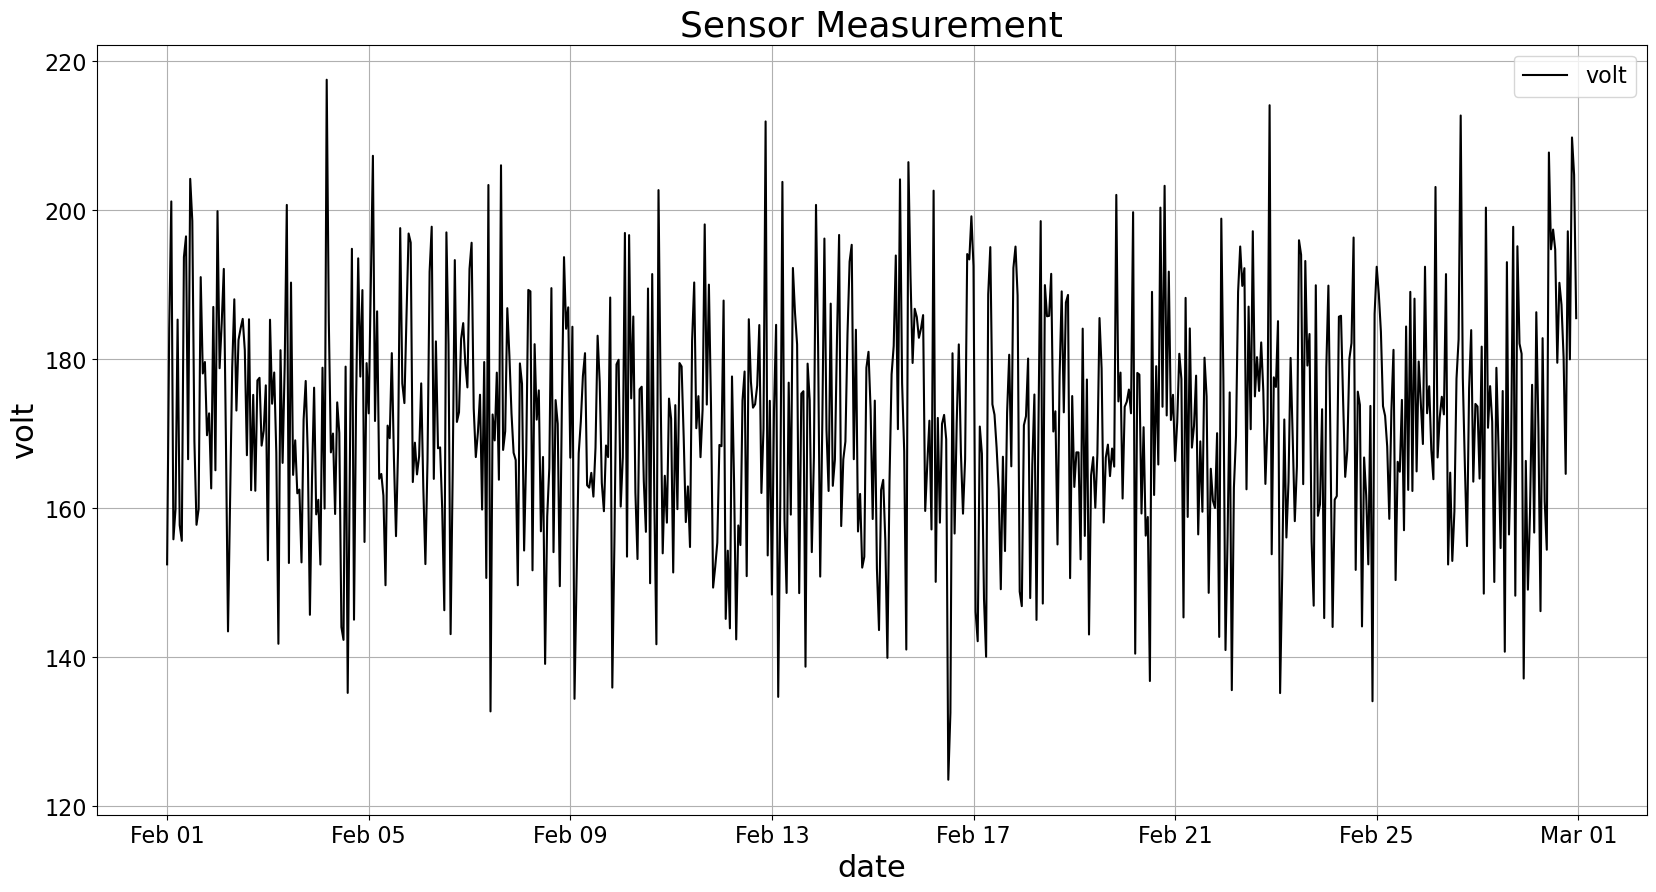

In [8]:
# Extract February data
data = sen_data[[True if data.strftime("%B") == 'February' else False for data in sen_data['datetime']]]
data = data.reset_index(drop=True) 
"""The code data.reset_index(drop=True) resets the index of the data DataFrame or Series to start from 0, 
and drops the old index. By setting drop=True, the old index is dropped and a new one is created, 
with the row numbers starting from 0. Without drop=True, the old index would be kept as an additional column 
in the DataFrame.
"""

fig, ax =  plt.subplots(figsize=(20,10))

# Plot data
ax.plot(data['datetime'], data['volt'], color='black', label='volt')

# Format X axis - DateTime
# date_form = DateFormatter("%m-%d")
date_form = DateFormatter("%b %d")
ax.xaxis.set_major_formatter(date_form)

plt.title("Sensor Measurement", fontsize = 26)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlabel("date", fontsize = 22)
plt.ylabel("volt", fontsize = 22)
plt.grid()
plt.legend(fontsize = 16, bbox_to_anchor=(1, 1))

plt.show()

Computing the rolling mean of 20 readings will give:

In [9]:
win_size = 20
data = data.sort_values(by='datetime', ascending = True) # Ensure time order is preserved
data['roll_volt'] = np.nan
for i in range(len(data)-20+1):
    data.at[i+win_size-1, 'roll_volt'] = data['volt'][i:i+win_size].mean()

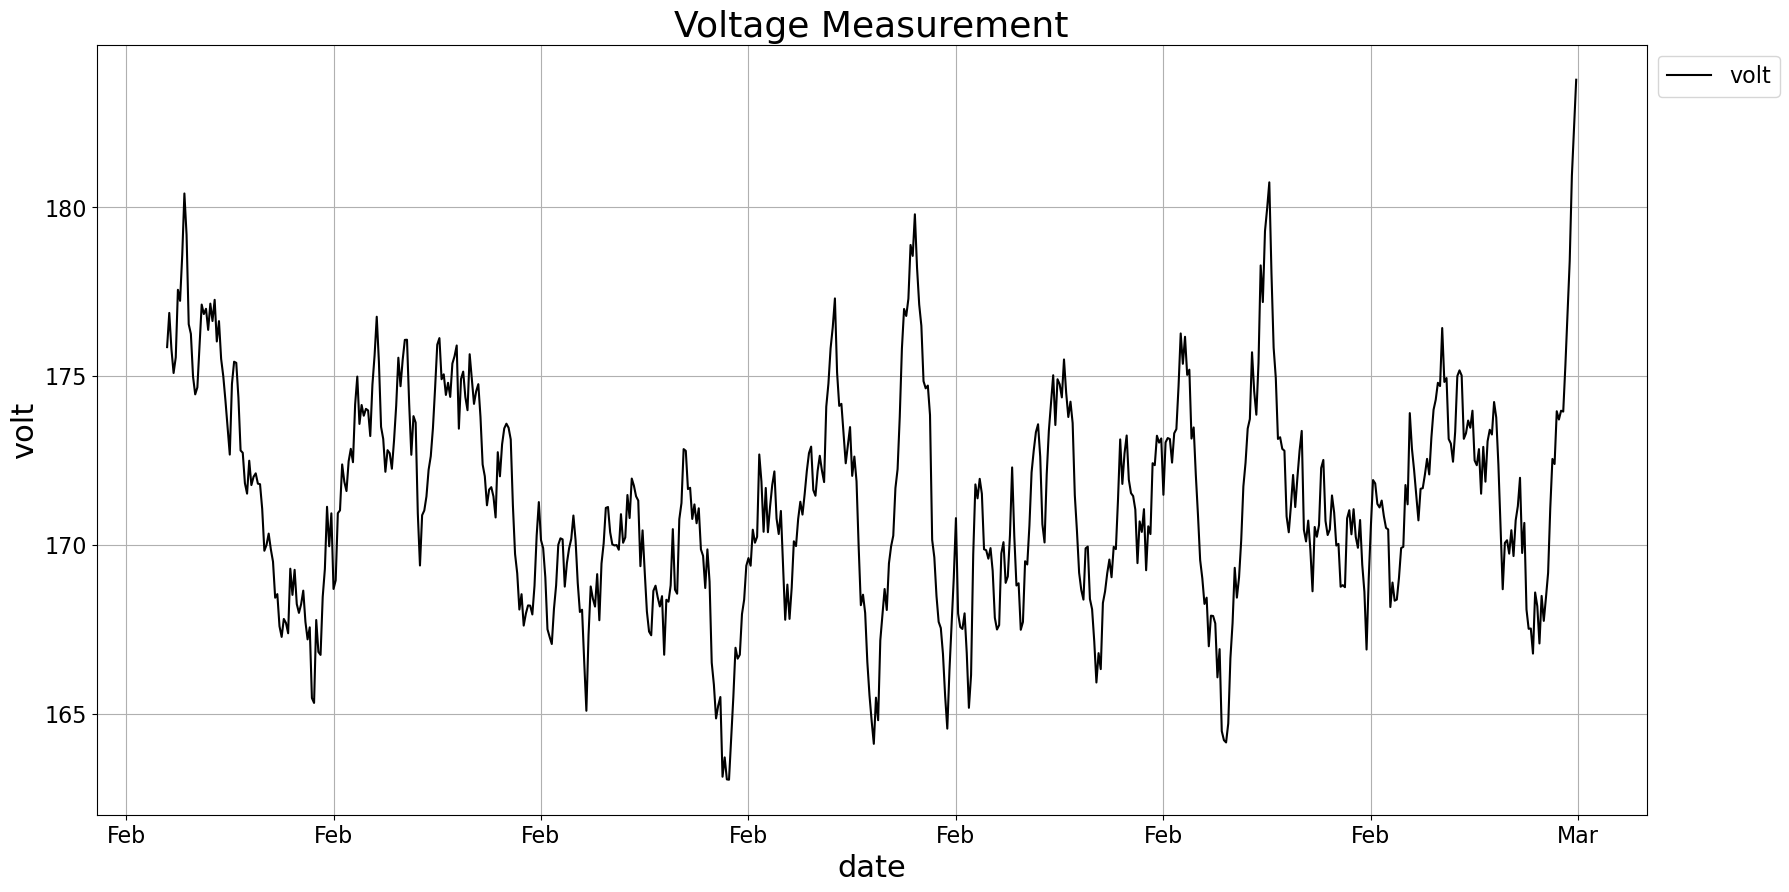

In [10]:
fig, ax =  plt.subplots(figsize=(20,10))

# Plot data
ax.plot(data['datetime'], data['roll_volt'], color='black', label='volt')

# Format X axis - DateTime
# date_form = DateFormatter("%m-%d")
date_form = DateFormatter("%b")
ax.xaxis.set_major_formatter(date_form)

plt.title("Voltage Measurement", fontsize = 26)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlabel("date", fontsize = 22)
plt.ylabel("volt", fontsize = 22)
plt.grid()
plt.legend(fontsize = 16, bbox_to_anchor=(1, 1))

plt.show()

Let us write a general purpose `function` that will compute sliding window `mean` for all the sensor columns.

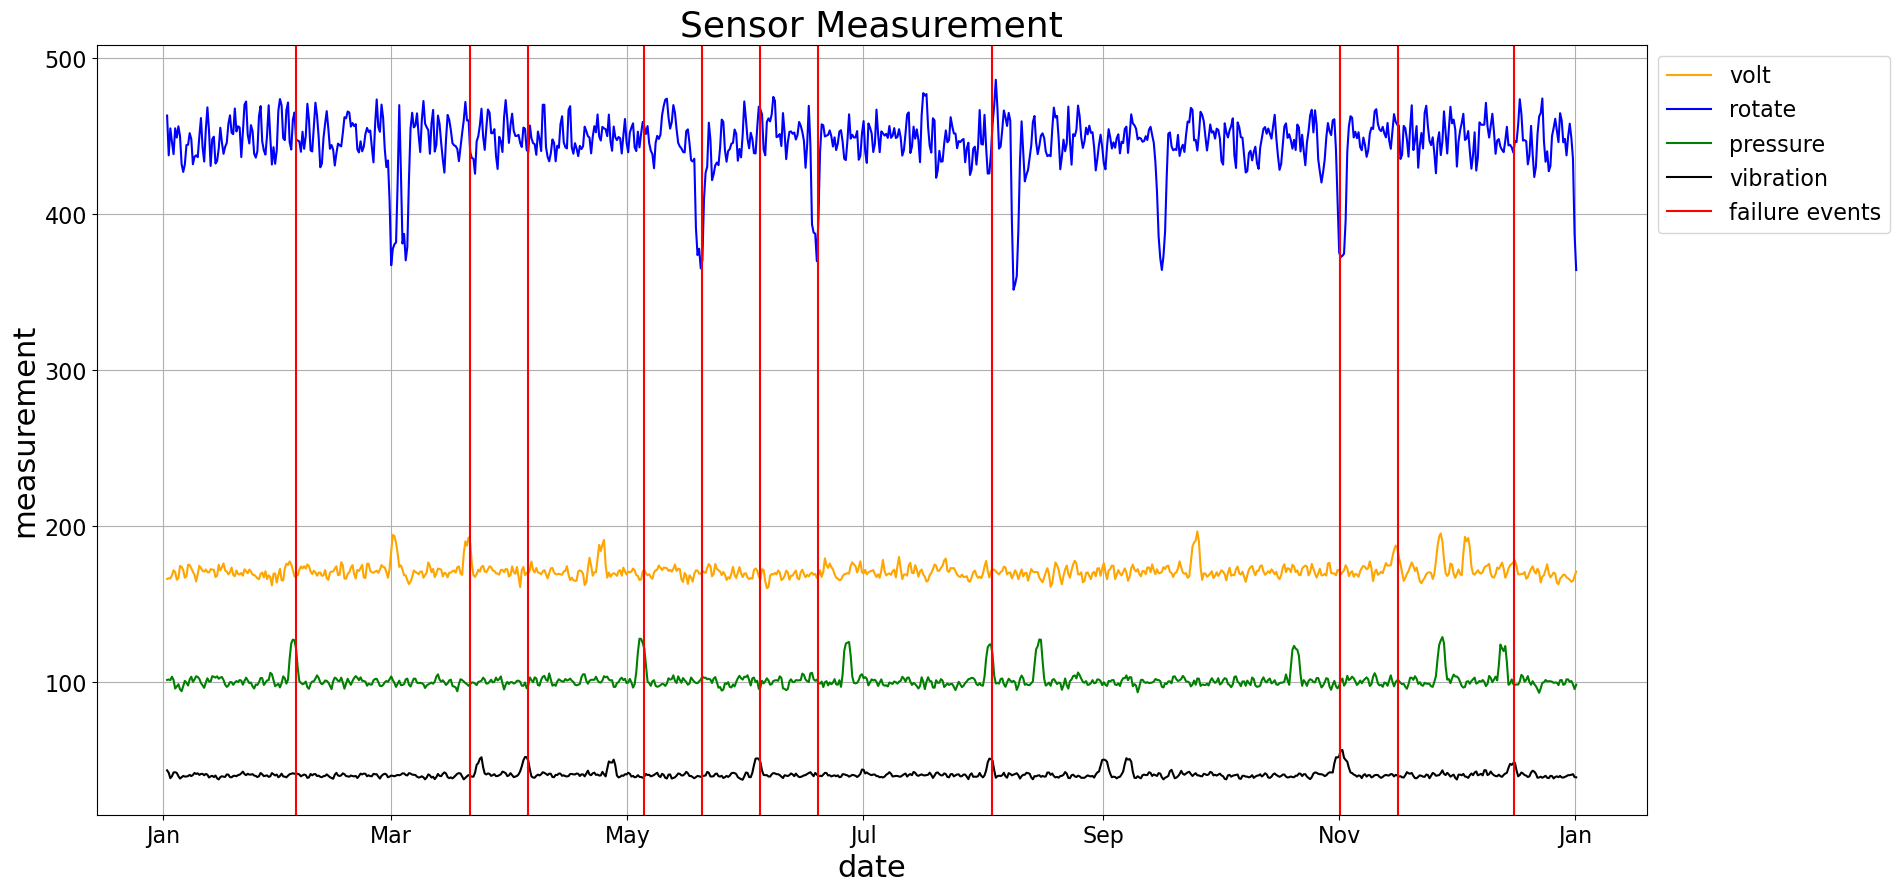

In [11]:
def sliding_mean(data, win_size, step_size=1):
    """
    input:
    data: type(dataframe) 
    win_size: window size type(int)
    step_size: type(int)
    """
    # initiallization n lists according to the column name
    data_dict = {}
    for col_name in data.columns:
        data_dict[col_name] = []
    
    # process along the column 
    for col_name in data.columns:
        i = 0
        while i < (len(data)-win_size):
            if(col_name == 'datetime'): # keep the datetime
                data_dict[col_name].append(data[col_name][i+win_size-1])
            else:   
                # rolling mean for data
                data_dict[col_name].append(data[col_name][i:i+win_size].mean())
            i += step_size
        
    return (pd.DataFrame(data_dict)) # transfer to pd.df

slide_mean_data = sliding_mean(sen_data, 20, 10)

plot_diagnostic_data(slide_mean_data, fail_dt, None)

## 4 Failure prediction

How can we predict failures in machines given sensor measurements? One way to do it is to use classification algorithms. Let us try one of them here.

### 4.1 Preparing the data
Before we embark on building classification models, let us separate the data into training and test sets.

In [12]:
print("start date :",sen_data['datetime'][0])
print("end date :",sen_data['datetime'].iloc[-1])

start date : 2015-01-01 06:00:00
end date : 2016-01-01 06:00:00


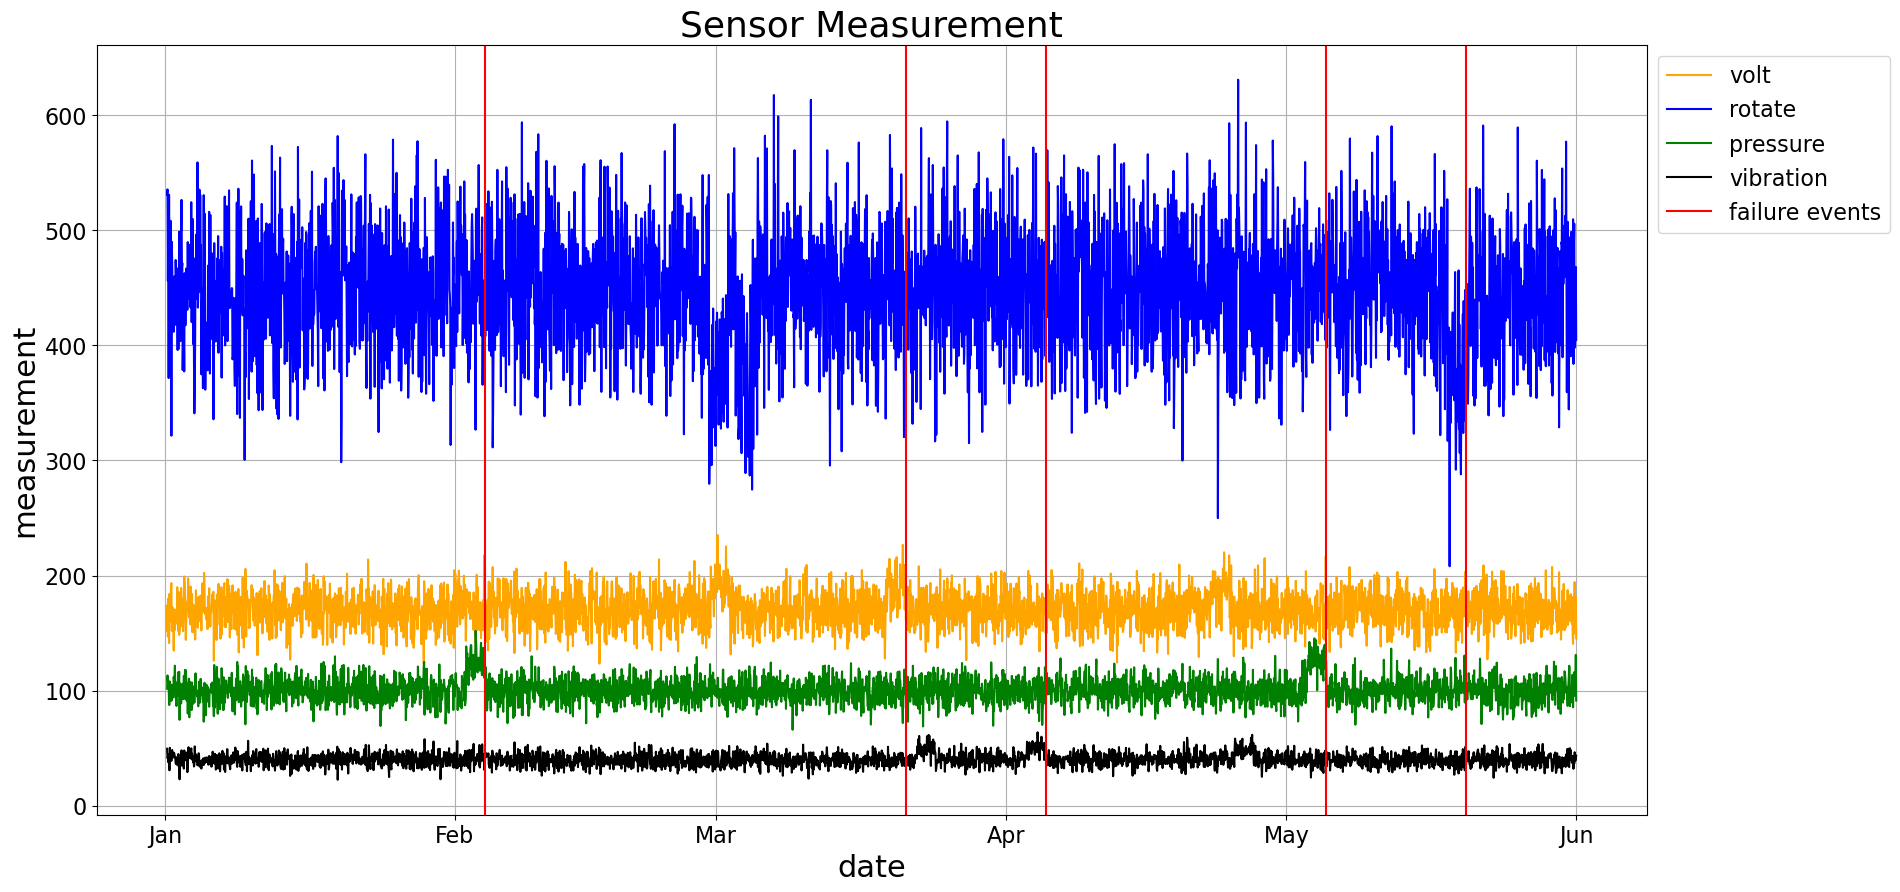

In [13]:
train_tp = pd.to_datetime("2015-06-01") # training set stop date
train_data = sen_data[sen_data['datetime'] <= train_tp] 
"""
selects all rows from sen_data where the value in the datetime column is less than or equal to train_tp. 
This creates a new DataFrame train_data that only includes data up to June 1st, 2015.
"""
train_data_fail = fail_dt[fail_dt['datetime'] <= train_tp]

plot_diagnostic_data(train_data, train_data_fail, None)

As discussed, lets use a sliding window to transform the data.

In [14]:
train_data = sliding_mean(train_data, 20, 10)

In [15]:
train_data.head(5)

datetime        volt      rotate    pressure  vibration
0 2015-01-02 01:00:00  165.986300  463.146618  101.252537  43.257060
1 2015-01-02 11:00:00  166.481762  437.660900  101.532750  41.730663
2 2015-01-02 21:00:00  166.287348  454.921207  101.167522  38.284306
3 2015-01-03 07:00:00  168.322989  446.274223  103.356567  39.485176
4 2015-01-03 17:00:00  171.531552  438.418174  101.218941  41.933467

In [16]:
display(train_data_fail)

datetime
0 2015-02-04 06:00:00
1 2015-03-21 06:00:00
2 2015-04-05 06:00:00
3 2015-05-05 06:00:00
4 2015-05-20 06:00:00

For classification, we need a training data set with inputs and outputs. Let us match the failure events as outputs.

In [17]:
train_data['state'] = 'normal'
for dt in train_data_fail['datetime']:
    for i in range(len(train_data)):
        # Find time point that was just before failure event
        if(dt < train_data['datetime'][i]):
            train_data.at[i-1, 'state'] = 'failure'
            break
            
train_data['state'].value_counts()

normal     355
failure      5
Name: state, dtype: int64

when logging fail, there is not any sensor data

### 4.2  k Nearest Neighbour (kNN) Model

Let us build a kNN model for failure prediction.

In [18]:
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(train_data[train_data.columns.difference(['datetime', 'state'])], train_data['state'])
"""
train_data[train_data.columns.difference(['datetime', 'state'])] returns a dataframe consisting of all columns
in train_data except for the columns named 'datetime' and 'state'.
"""

"\ntrain_data[train_data.columns.difference(['datetime', 'state'])] returns a dataframe consisting of all columns\nin train_data except for the columns named 'datetime' and 'state'.\n"

Using the model, let us check the prediction for the whole data set.

In [19]:
all_data = sliding_mean(sen_data, 20, 10)
knn_predict = knn_model.predict(all_data[all_data.columns.difference(['datetime', 'state'])])
knn_fail_dt = all_data[knn_predict=='failure']['datetime'].to_frame().reset_index() 
# just extract the predicted failed datetime
knn_fail_dt

C:\Users\27152\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


index            datetime
0     78 2015-02-03 13:00:00
1     79 2015-02-03 23:00:00
2    423 2015-06-27 07:00:00
3    792 2015-11-28 01:00:00

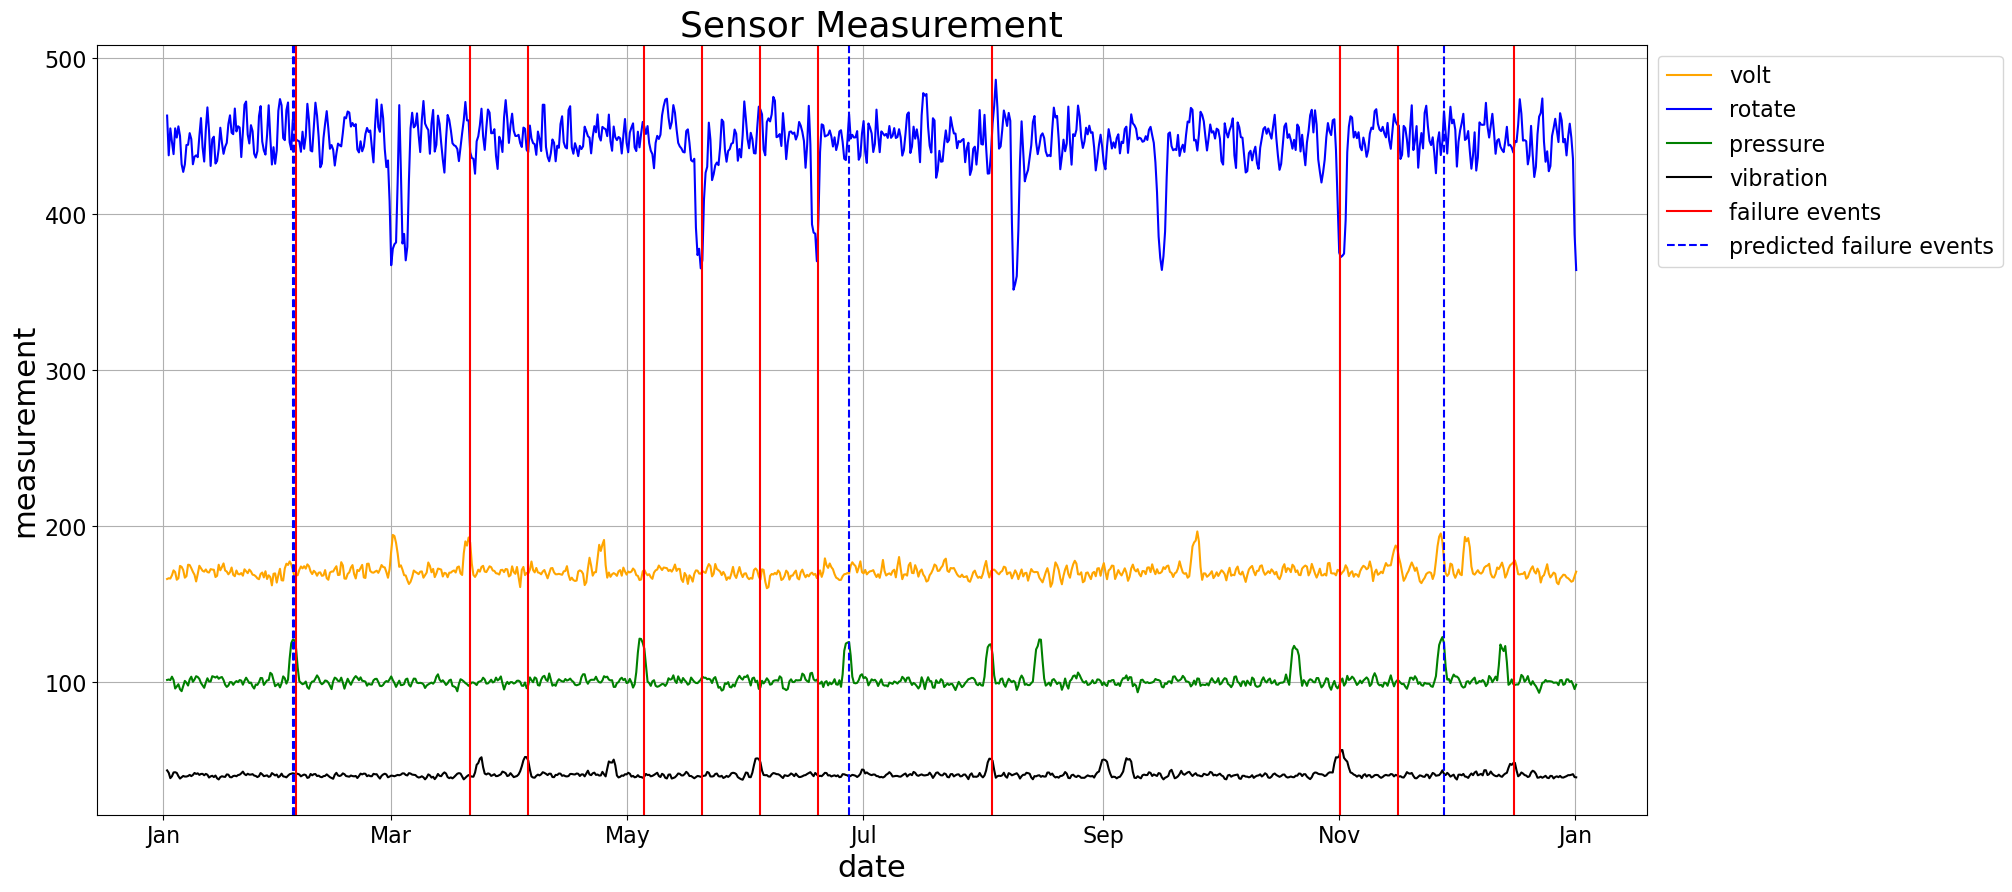

In [20]:
plot_diagnostic_data(all_data, fail_dt, knn_fail_dt)

kNN predicts only 4 failure events (blue dashed lines).

In [21]:
true_state = {'datetime' : all_data['datetime'],
              'state' : ['normal']*len(all_data)}
true_state = pd.DataFrame(true_state)
for dt in fail_dt['datetime']:
    for i in range(len(true_state)):
        # Find time point that was just before failure event
        if(dt < true_state['datetime'][i]):
            true_state.at[i-1, 'state'] = 'failure'
            break

true_state = np.array(true_state['state'])

The true states are compared to the predicted states to form the confusion matrix and compute other classification metrics such as accuracy and GMean score which is sqrt(recall*specificity).

In [22]:
def classification_metrics(predicted, true):
    cm = confusion_matrix(true, predicted, labels = ['failure', 'normal'])
    print("Confusion Matrix:")
    print("             Predicted")
    print("             failure normal")
    print("True failure       " + str(cm[0][0]) + "      " + str(cm[0][1]))
    print("      normal       " + str(cm[1][0]) + "     " + str(cm[1][1]))

    acc = accuracy_score(true, predicted)*100
    gm = np.sqrt(np.prod([cm.diagonal()/np.sum(cm, axis=1)]))*100
    print('\nWith accuracy of {0:.2f}% and GMean score of {1:.2f}%'.format(acc, gm))

# Write the code to compute Recall, Specificity, Precision and F-score in the function above
# Print out these results   

Evaluating for kNN model,

In [23]:
classification_metrics(knn_predict, true_state)

Confusion Matrix:
             Predicted
             failure normal
True failure       1      10
      normal       3     861

With accuracy of 98.51% and GMean score of 30.10%


### 5  Other Failure Prediction Method 1: Full Bayesian

Wang Ruilin A0260074M


#### Firstly, choose the appropriate slide window size by evaluating SNR
consider noise as the mean value of the sequence and signal as the amplitude/standard deviation

In [24]:
window_size = np.arange(2,50,1) # window size range
SNR = np.zeros((len(window_size),len(window_size),4))
row = 0
for win in window_size:
    step_size = np.arange(1,win,1)# step size must no more than window size
    for step in step_size:
        slide_mean_data = sliding_mean(sen_data, win, step)
        # compute SNR
        for i in range(4):
#             noise = slide_mean_data.iloc[:,i+1].mean()
            signal = (slide_mean_data.iloc[:,i+1].max() - slide_mean_data.iloc[:,i+1].min()) / slide_mean_data.iloc[:,i+1].std()
            snr = 20 * np.log10(signal)
            SNR[row,step-1,i] = snr
    row += 1
        

Max point: (24.00, 1.00, 18.25)
Max point: (17.00, 1.00, 18.43)
Max point: (23.00, 1.00, 18.38)
Max point: (12.00, 1.00, 18.36)
Max point: (30.00, 1.00, 18.29)
Max point: (3.00, 1.00, 18.67)
Max point: (8.00, 1.00, 18.38)
Max point: (5.00, 1.00, 18.43)
Max point: (4.00, 1.00, 18.44)
Max point: (2.00, 1.00, 18.72)


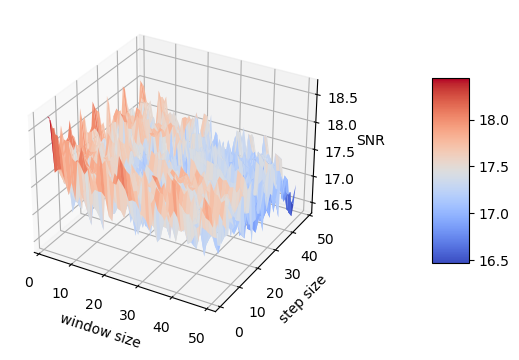

In [25]:
from mpl_toolkits.mplot3d import Axes3D

def mesh_plot(data):
    X = np.arange(2, len(data)+2, 1) # grid coordinates of window_size
    Y = np.arange(1, len(data)+1, 1) # grid coordinates of step_size
    X, Y = np.meshgrid(X, Y)
    # Create new matrix and copy lower triangle to upper triangle
    new_matrix = np.zeros_like(data)
    new_matrix[np.triu_indices_from(new_matrix)] = data[np.tril_indices_from(data)]

    # Copy upper triangle to lower triangle
    new_matrix[np.tril_indices_from(new_matrix)] = new_matrix.T[np.tril_indices_from(new_matrix)]
    
    # Find the maximum point
    # Get the indices that would sort the array in descending order
    k = 20
    indices = np.argpartition(new_matrix.flatten(), -k)[-k:]
    # Convert the flat indices to 2D indices
    max_idx = np.unravel_index(indices, new_matrix.shape)
    # Get the top k elements
    max_z = new_matrix[max_idx]
    max_x = X[max_idx]
    max_y = Y[max_idx]


    # create figure and axes
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # plot surface
    surf = ax.plot_surface(X, Y, new_matrix, cmap='coolwarm', edgecolor='none')
    
    # Add an annotation for the maximum point
    for i in range(k):
        if max_x[i] > max_y[i]:
            print(f"Max point: ({max_x[i]:.2f}, {max_y[i]:.2f}, {max_z[i]:.2f})")

    # set axis labels
    ax.set_xlabel('window size')
    ax.set_ylabel('step size')
    ax.set_zlabel('SNR')


    # add color bar
    fig.colorbar(surf, shrink=0.5, aspect=5,pad=0.2)

    # show plot
    plt.show()

SNR_avg = np.mean(SNR,axis=2)
mesh_plot(SNR_avg)

According to the SNR result, we can set the window size and step size for every column. However, if the window size is too small, the performance of rolling mean filter is weak. Therefore, we choose window size = 30 and step size = 1

#### Secondly, filter the data using selected rolling mean and visualized the result

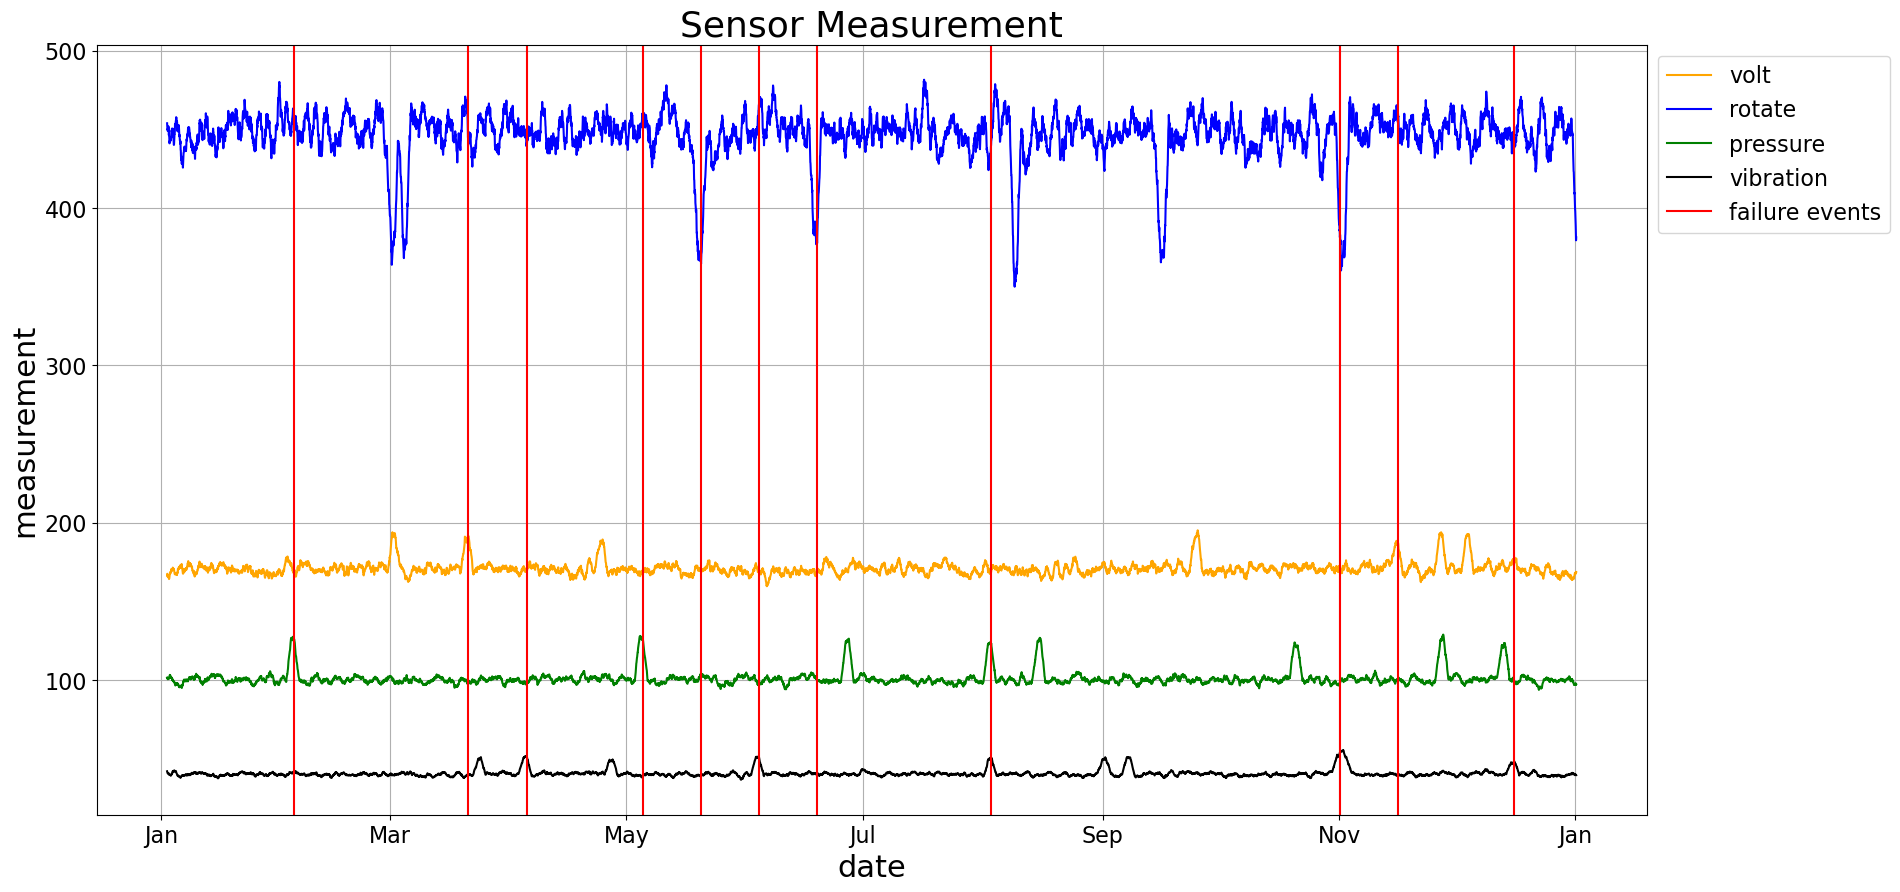

In [16]:
window_size = 30
slide_mean_data = sliding_mean(sen_data, window_size, 1)
plot_diagnostic_data(slide_mean_data, fail_dt, None)

In [14]:
# train test data split
def train_test_split(sen_data,fail_dt,stop_date,window_size,step_size=1):
    """
    sen_data: sensor data type(pd.df)
    fail_dt: fail data type(pd.df)
    stop_date: the end date of training set type(str)
    window_size: rolling mean filter window size type(int)
    step_size: rolling mean filter step size type(int) default_value(1)
    """
    
    # generate training set 
    train_tp = pd.to_datetime(stop_date) # training set stop date
    train_data = sen_data[sen_data['datetime'] <= train_tp] 
    train_data_fail = fail_dt[fail_dt['datetime'] <= train_tp]
    train_data = sliding_mean(train_data, window_size, step_size)
    train_data['state'] = 'normal'
    for dt in train_data_fail['datetime']:
        for i in range(len(train_data)):
            # Find time point that was just before failure event
            if(dt < train_data['datetime'][i]):
                train_data.at[i-1, 'state'] = 'failure'
                break

    print(train_data['state'].value_counts())
    
    # generate test set which is the whole data set
    test_data = sliding_mean(sen_data, window_size, step_size)
    
    # generate ground truth
    true_state = {'datetime' : test_data['datetime'],
              'state' : ['normal']*len(test_data)}
    true_state = pd.DataFrame(true_state)
    for dt in fail_dt['datetime']:
        for i in range(len(true_state)):
            # Find time point that was just before failure event
            if(dt < true_state['datetime'][i]):
                true_state.at[i-1, 'state'] = 'failure'
                break

    true_state = np.array(true_state['state'])
    
    return train_data,test_data,true_state

train_data,test_data,true_state = train_test_split(sen_data,fail_dt,'2015-06-01',30)

normal     3584
failure       5
Name: state, dtype: int64


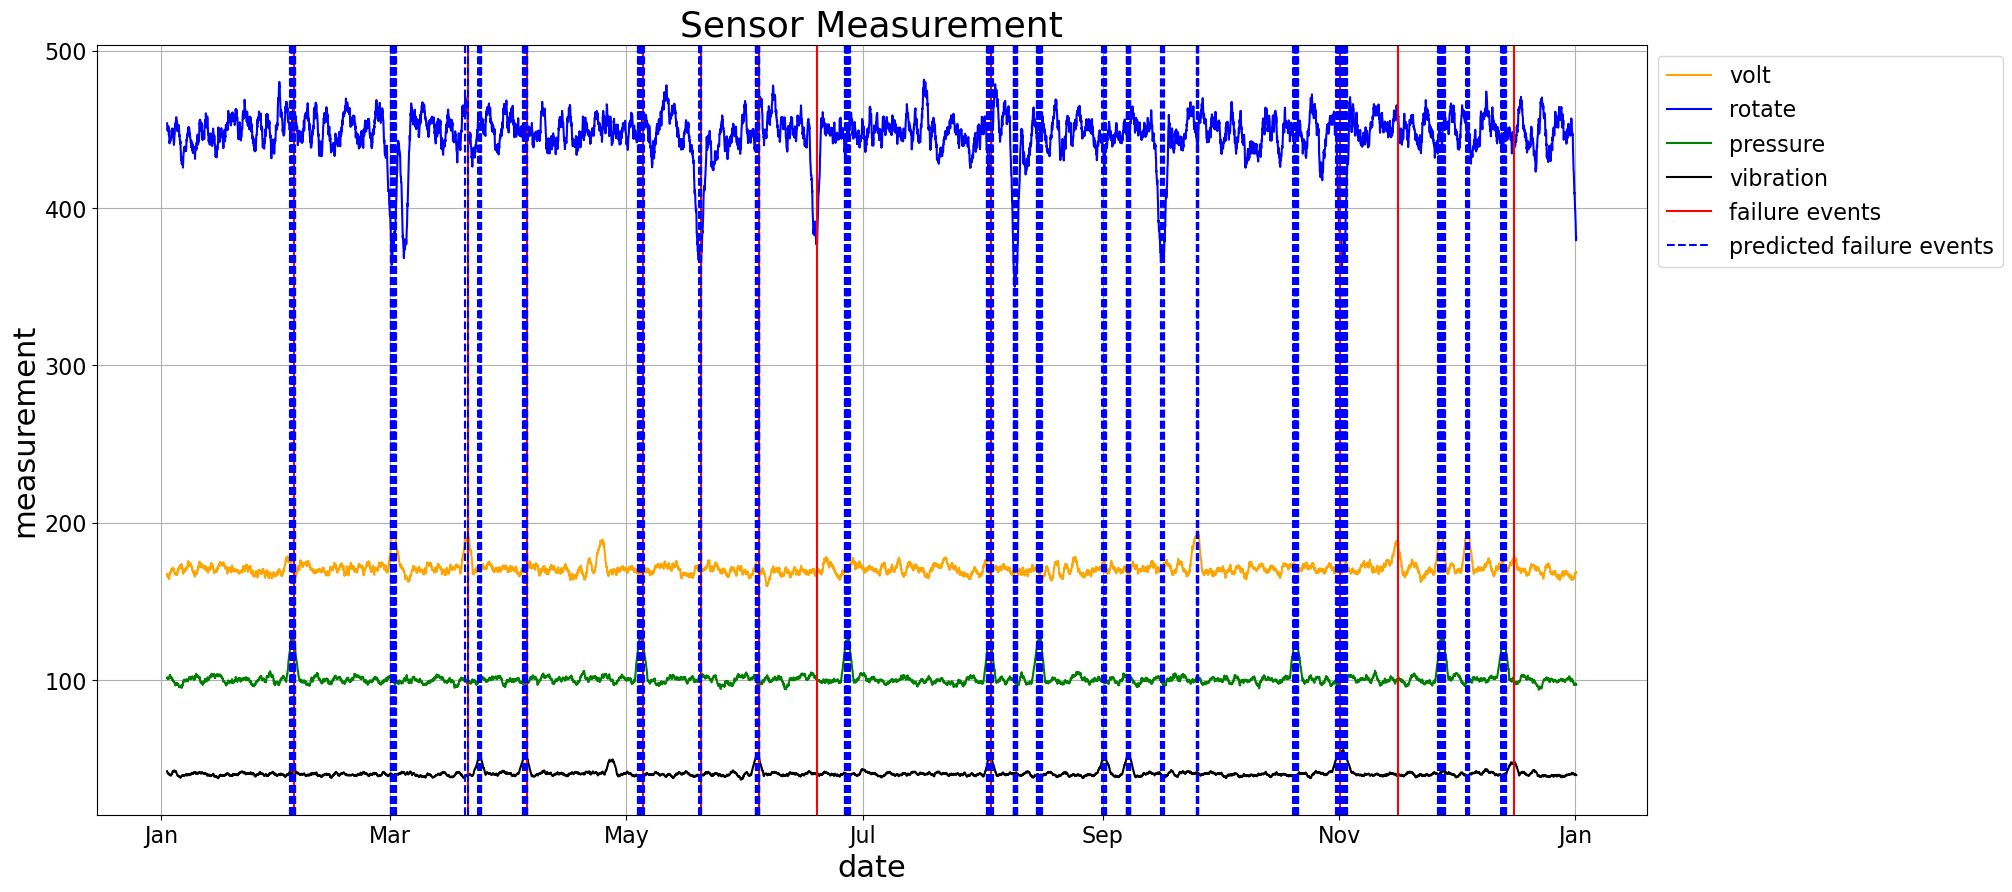

In [15]:
from sklearn.naive_bayes import GaussianNB

# Instantiate and fit the model
gnb = GaussianNB()
gnb.fit(train_data[train_data.columns.difference(['datetime', 'state'])], train_data['state'])

# use model predict label for test data
gnb_predict = gnb.predict(test_data[test_data.columns.difference(['datetime', 'state'])])
gnb_fail_dt = test_data[gnb_predict=='failure']['datetime'].to_frame().reset_index() 
plot_diagnostic_data(test_data, fail_dt, gnb_fail_dt)

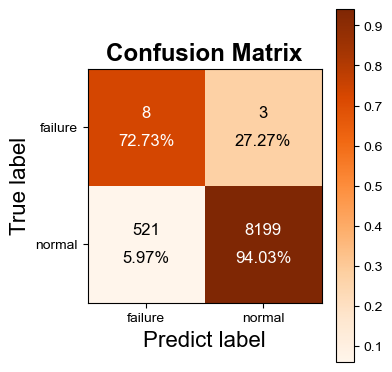

The accuracy of the model is 0.940
The GMean of the model is 0.827
The recall of the model is 0.727
The specificity of the model is 0.940
The precision of the model is 0.015
The F1 of the model is 0.030


In [17]:
from matplotlib import rcParams
from math import log
# plot confusion matrix
def confusion_m(predicted, true):
    
    # generate confusion matrix
    cm = confusion_matrix(true, predicted, labels = ['failure', 'normal'])
    person = ['failure', 'normal']
    
    # get proportion of every grid
    proportion=[]
    for i in cm:
        for j in i:
            temp=j/(np.sum(i))
            proportion.append(temp)

    # generate the percentage
    percentage=[]
    for i in proportion:
        pt="%.2f%%" % (i * 100)
        percentage.append(pt)
        
    proportion=np.array(proportion).reshape(len(person),len(person))  
    percentage=np.array(percentage).reshape(len(person),len(person))
    
    # set the font
    config = {"font.family":'Arial'}
    rcParams.update(config)
    
    #
    # plot the confusion matrix
    #
    fig = plt.figure( figsize=(4,4) )
    plt.imshow(proportion, interpolation='nearest', cmap=plt.cm.Oranges)  
                # ('Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds','YlOrBr', 'YlOrRd',
                # 'OrRd', 'PuRd', 'RdPu', 'BuPu','GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn')
    plt.title('Confusion Matrix',fontsize='xx-large',fontweight='heavy')
    plt.colorbar()
    tick_marks = np.arange(len(person))
    plt.xticks(tick_marks, person)
    plt.yticks(tick_marks, person)

    # plot the percentage
    thresh = cm.max() / 2.
    fs = int( 9 / log(len(person)) )
    iters = np.reshape([[[i,j] for j in range(len(person))] for i in range(len(person))],(cm.size,2))
    for i, j in iters:
        if(i==j):
            plt.text(j, i - 0.12, format(cm[i, j]), va='center', ha='center',color='white',weight=5,fontsize=fs)  
            plt.text(j, i + 0.12, percentage[i, j], va='center', ha='center',color='white',fontsize=fs)
        else:
            plt.text(j, i-0.12, format(cm[i, j]),va='center',ha='center',fontsize=fs)   
            plt.text(j, i+0.12, percentage[i, j], va='center', ha='center',fontsize=fs)

    plt.ylabel('True label',fontsize=16)
    plt.xlabel('Predict label',fontsize=16)
    plt.tight_layout()
    plt.show()
    
    total = len(predicted)
    # calculate accuarcy
    TP_m = np.sum(cm * np.eye(len(person)).astype(int),axis = 1)
    TP = TP_m[0]
    accuracy = np.sum(TP_m) / total 
    print('The accuracy of the model is %.3f' % (accuracy * 1))
    
    # calculate GMean
    gm = np.sqrt(np.prod([cm.diagonal()/np.sum(cm, axis=1)]))
    print('The GMean of the model is %.3f' % (gm * 1))
    
    # calculate recall
    FN = cm[0,1]
    recall = TP / ( TP + FN )
    print('The recall of the model is %.3f' % (recall * 1))
    
    # calculate specificity
    TN = cm[1,1]
    FP = cm[1,0]
    specificity = TN / ( TN + FP )
    print('The specificity of the model is %.3f' % (specificity * 1))
    
    # calculate precision
    precision = TP / ( TP + FP )
    print('The precision of the model is %.3f' % (precision * 1))
    
    # calculate F1
    F1 = 2 * recall * precision / ( recall + precision )
    print('The F1 of the model is %.3f' % (F1 * 1))
    


confusion_m(gnb_predict, true_state)

### 6  Other Failure Prediction Method 2

Name and Student No.

Write the code for the proposed prediction method and fit or train the model.

You may change the window size and step size for the sliding mean, but all members in the same group must use the same values for these 2 parameters.

Use this method to predict failures for the entire duration in the dataset and evaluate its performance.

Show the diagnostic data graph with actual and predicted failures, and print out the six classification metrics.

normal     3584
failure       5
Name: state, dtype: int64


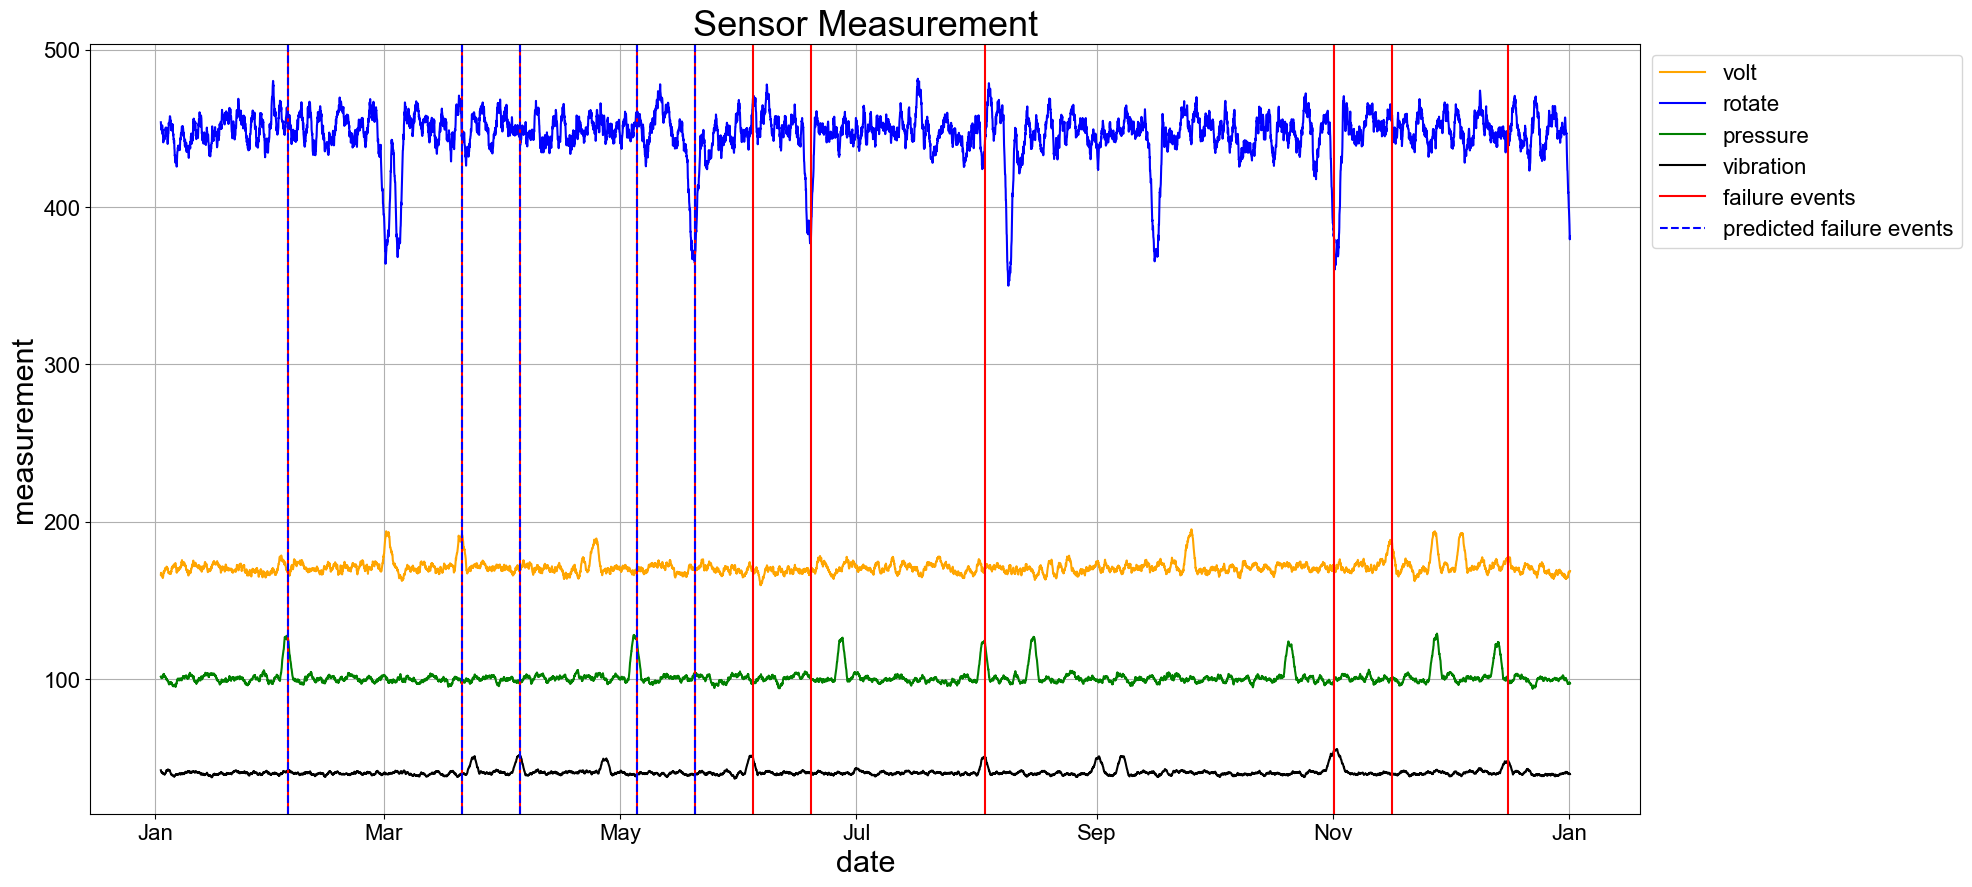

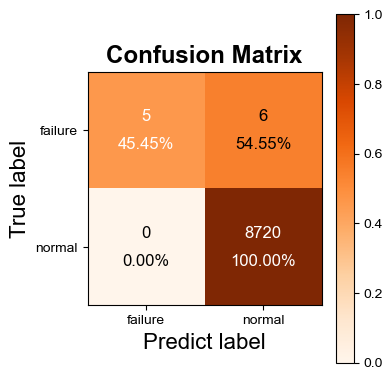

The accuracy of the model is 0.999
The GMean of the model is 0.674
The recall of the model is 0.455
The specificity of the model is 1.000
The precision of the model is 1.000
The F1 of the model is 0.625


In [31]:
from sklearn.ensemble import RandomForestClassifier

train_data,test_data,true_state = train_test_split(sen_data,fail_dt,'2015-06-01',30)

# create a random forest classifier with 100 trees
rfc = RandomForestClassifier(n_estimators=100, random_state=42)

# fit the model to the training data
rfc.fit(train_data[train_data.columns.difference(['datetime', 'state'])], train_data['state'])

# make predictions on the testing data
rfc_predict = rfc.predict(test_data[test_data.columns.difference(['datetime', 'state'])])
rfc_fail_dt = test_data[rfc_predict=='failure']['datetime'].to_frame().reset_index() 
plot_diagnostic_data(test_data, fail_dt, rfc_fail_dt)

# evaluate the performance of the model
confusion_m(rfc_predict, true_state)

### 7  Other Failure Prediction Method 3: Gaussian Maximum Likelihood 

Wang Wentao A0267528R


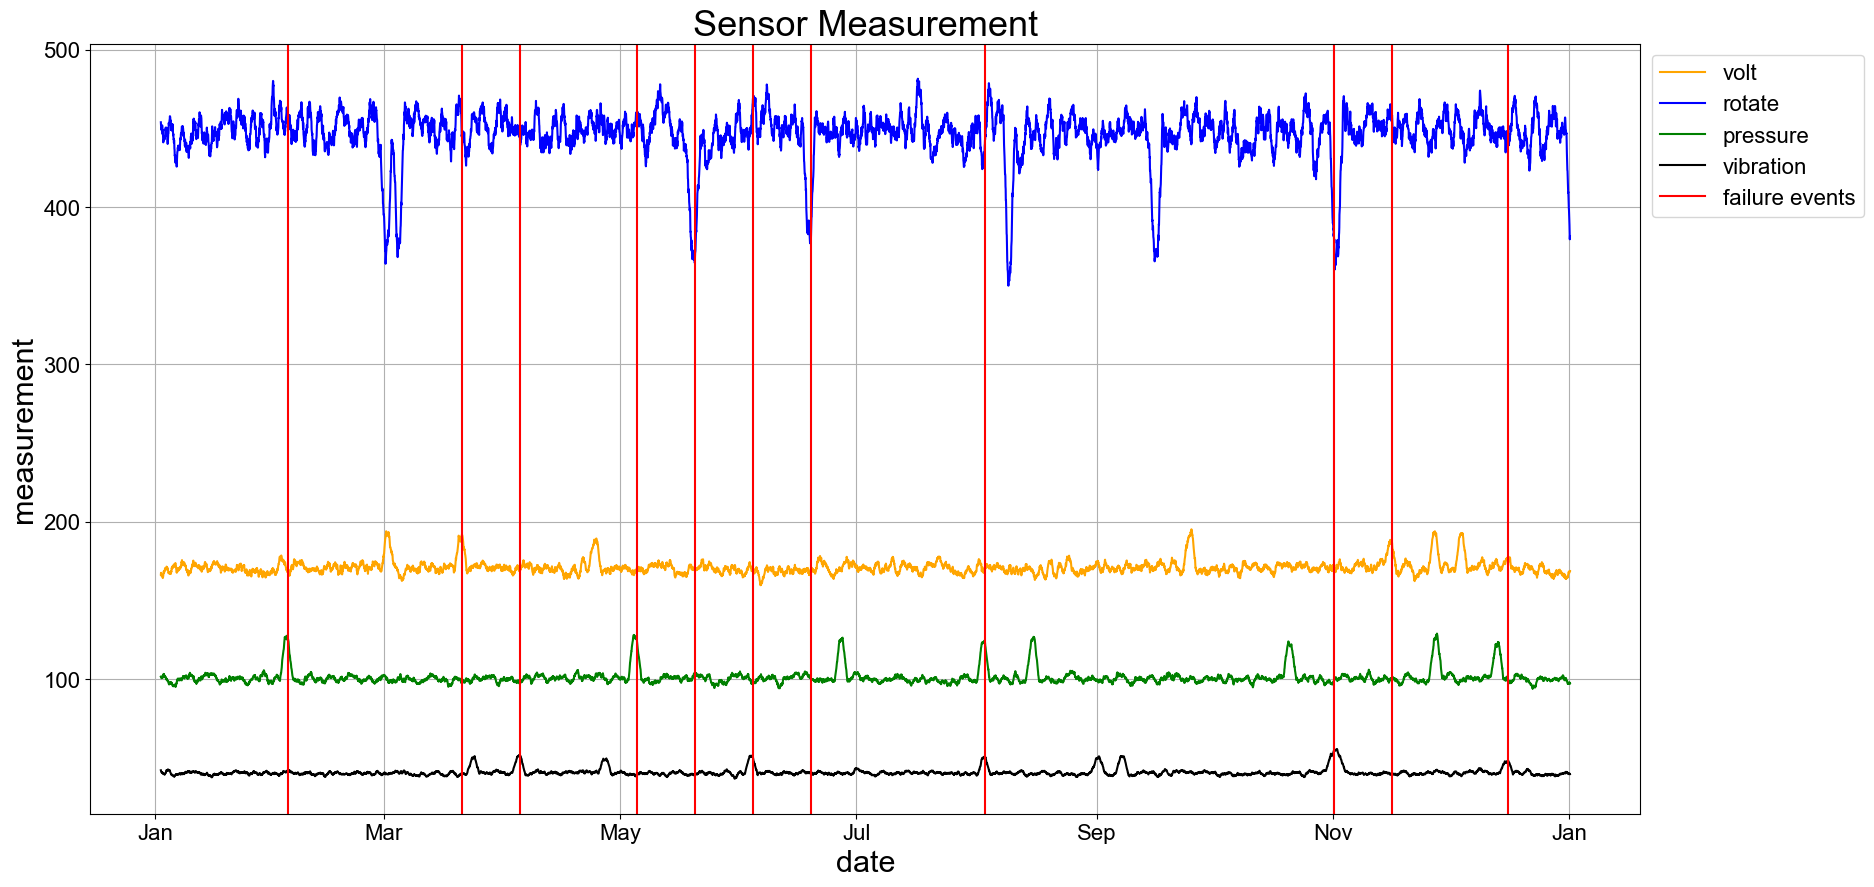

In [19]:
window_size = 30
slide_mean_data = sliding_mean(sen_data, window_size, 1)
plot_diagnostic_data(slide_mean_data, fail_dt, None)

In [20]:
class MLClassifier:
    def fit(self, x: np.ndarray, y: np.ndarray) -> None:
        '''
        x - numpy array of shape (n, d); n = #observations; d = #variables
        y - numpy array of shape (n,)
        '''
        # no. of variables / dimension
        self.d = x.shape[1]
        
        # no. of classes; assumes labels to be integers from 0 to nclasses-1
        self.class_names = y.unique()
        self.nclasses = len(y.unique())
        
        # list of means; mu_list[i] is mean vector for label i
        self.mu_list = []
        
        # list of inverse covariance matrices;
        # sigma_list[i] is inverse covariance matrix for label i
        # for efficiency reasons we store only the inverses
        self.sigma_inv_list = []
        
        # list of scalars in front of e^...
        self.scalars = []
        
        n = x.shape[0]
        for i in range(self.nclasses):
            
            # subset of obesrvations for label i
            cls_x = x[y == self.class_names[i]]
            
            mu = np.mean(cls_x, axis=0)
            
            
            # rowvar = False, this is to use columns as variables instead of rows
            sigma = np.cov(cls_x,rowvar=False,bias=False)


            if np.sum(np.linalg.eigvals(sigma) <= 0) != 0:
                # if at least one eigenvalue is <= 0 show warning
                print(f'Warning! Covariance matrix for label {cls} is not positive definite!\n')
            
            sigma_inv = np.linalg.inv(sigma)
            
            scalar = 1/np.sqrt(((2*np.pi)**self.d)*np.linalg.det(sigma))
            
            self.mu_list.append(mu)
            self.sigma_inv_list.append(sigma_inv)
            self.scalars.append(scalar)
    
    def _class_likelihood(self, x: np.ndarray)-> np.ndarray:
        '''
        x - numpy array of shape (d,)
        cls - class label
        
        Returns: likelihood of x under the assumption that class label is cls
        '''
        label = np.empty((x.shape[0]), dtype='U10')
        for i in range(x.shape[0]): 
            x_i = x.iloc[i, :]
            p = np.empty((2, 1))
            for j in range(self.nclasses): 
                mu = self.mu_list[j]
                sigma_inv = self.sigma_inv_list[j]
                scalar = self.scalars[j]
                exp = (-1/2)*np.dot(np.matmul(x_i-mu, sigma_inv), x_i-mu)
                p[j] = scalar * (np.e**exp)
            if p[0]>=p[1]:
                label[i]='normal'
            else:
                label[i]='failure'
        return label
    
    def predict(self, x: np.ndarray) -> np.ndarray:
        '''
        x - numpy array of shape (d,)
        Returns: predicted label
        '''
        
        label = self._class_likelihood(x)
        return label

In [21]:
train_data,test_data,true_state = train_test_split(sen_data,fail_dt,'2015-06-01',30)

mlc = MLClassifier()
mlc.fit(train_data[train_data.columns.difference(['datetime', 'state'])], train_data['state'])
mlc_predict = mlc.predict(test_data[test_data.columns.difference(['datetime', 'state'])])
mlc_fail_dt = test_data[mlc_predict=='failure']['datetime'].to_frame().reset_index() 

normal     3584
failure       5
Name: state, dtype: int64


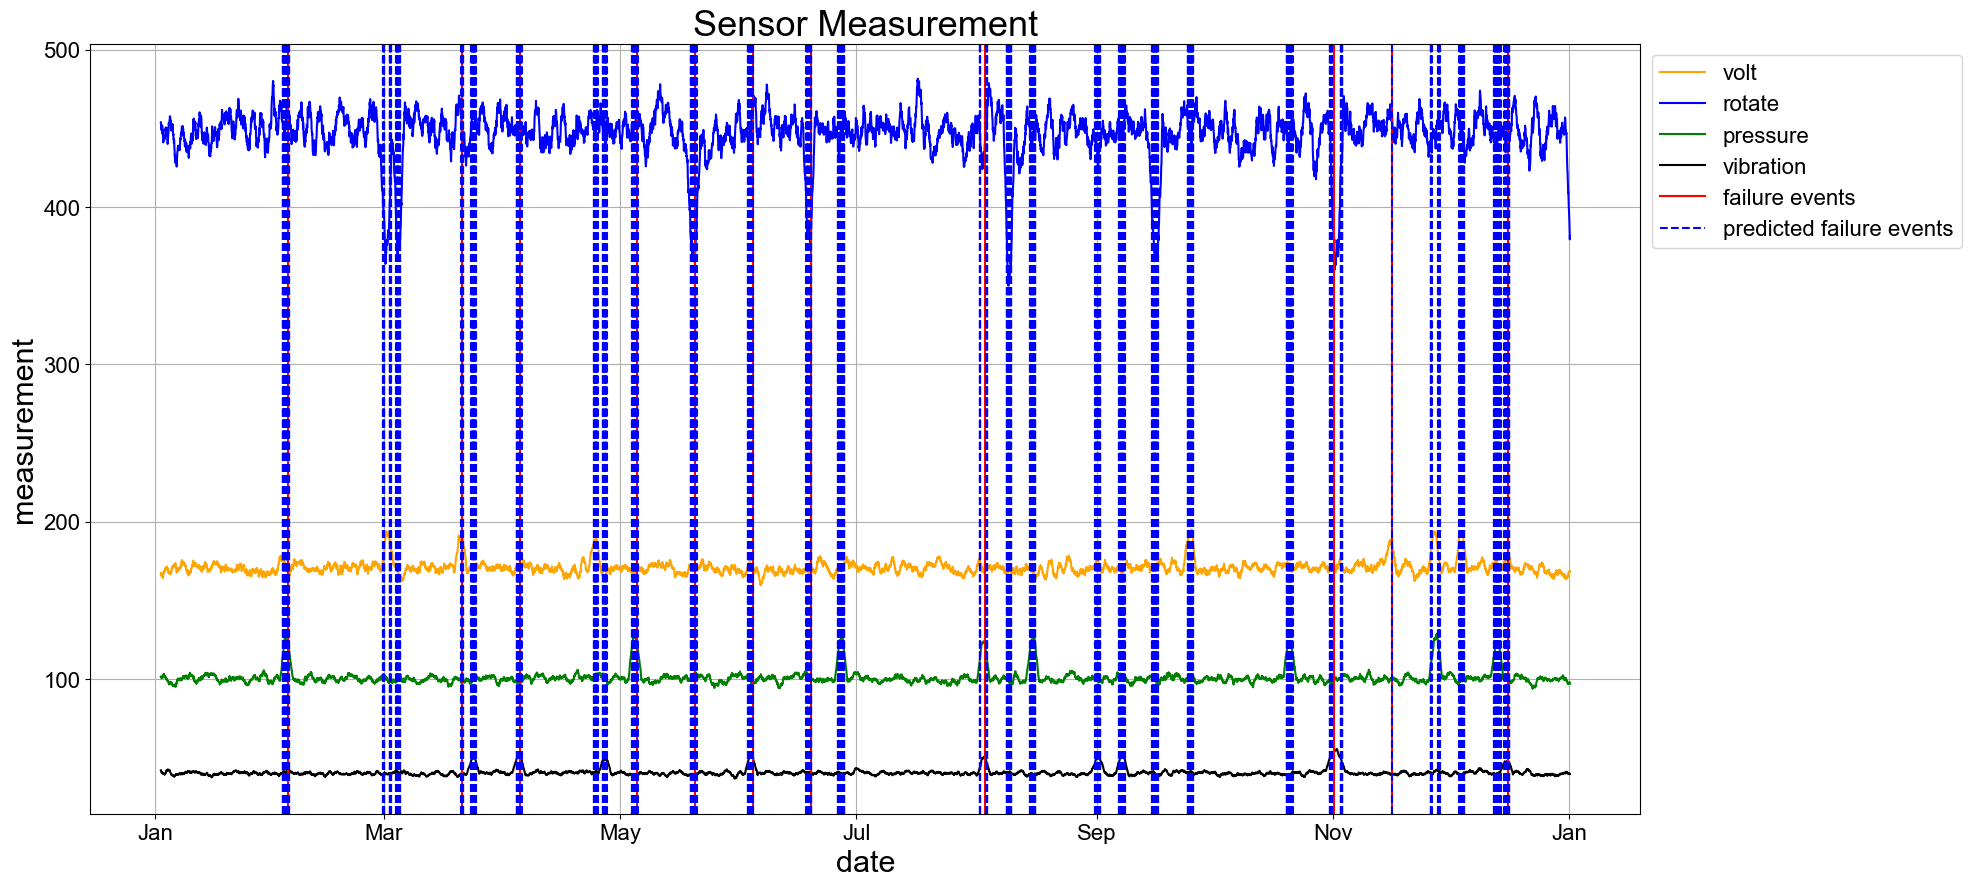

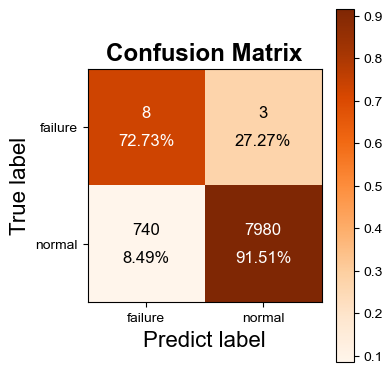

The accuracy of the model is 0.915
The GMean of the model is 0.816
The recall of the model is 0.727
The specificity of the model is 0.915
The precision of the model is 0.011
The F1 of the model is 0.021


In [22]:
plot_diagnostic_data(test_data, fail_dt, mlc_fail_dt)
confusion_m(mlc_predict, true_state)

### 8  Other Failure Prediction Method 4: SVM

Name and Student No.: Li Bingfan A0263755W

Write the code for the proposed prediction method and fit or train the model.

You may change the window size and step size for the sliding mean, but all members in the same group must use the same values for these 2 parameters.

Use this method to predict failures for the entire duration in the dataset and evaluate its performance.

Show the diagnostic data graph with actual and predicted failures, and print out the six classification metrics.

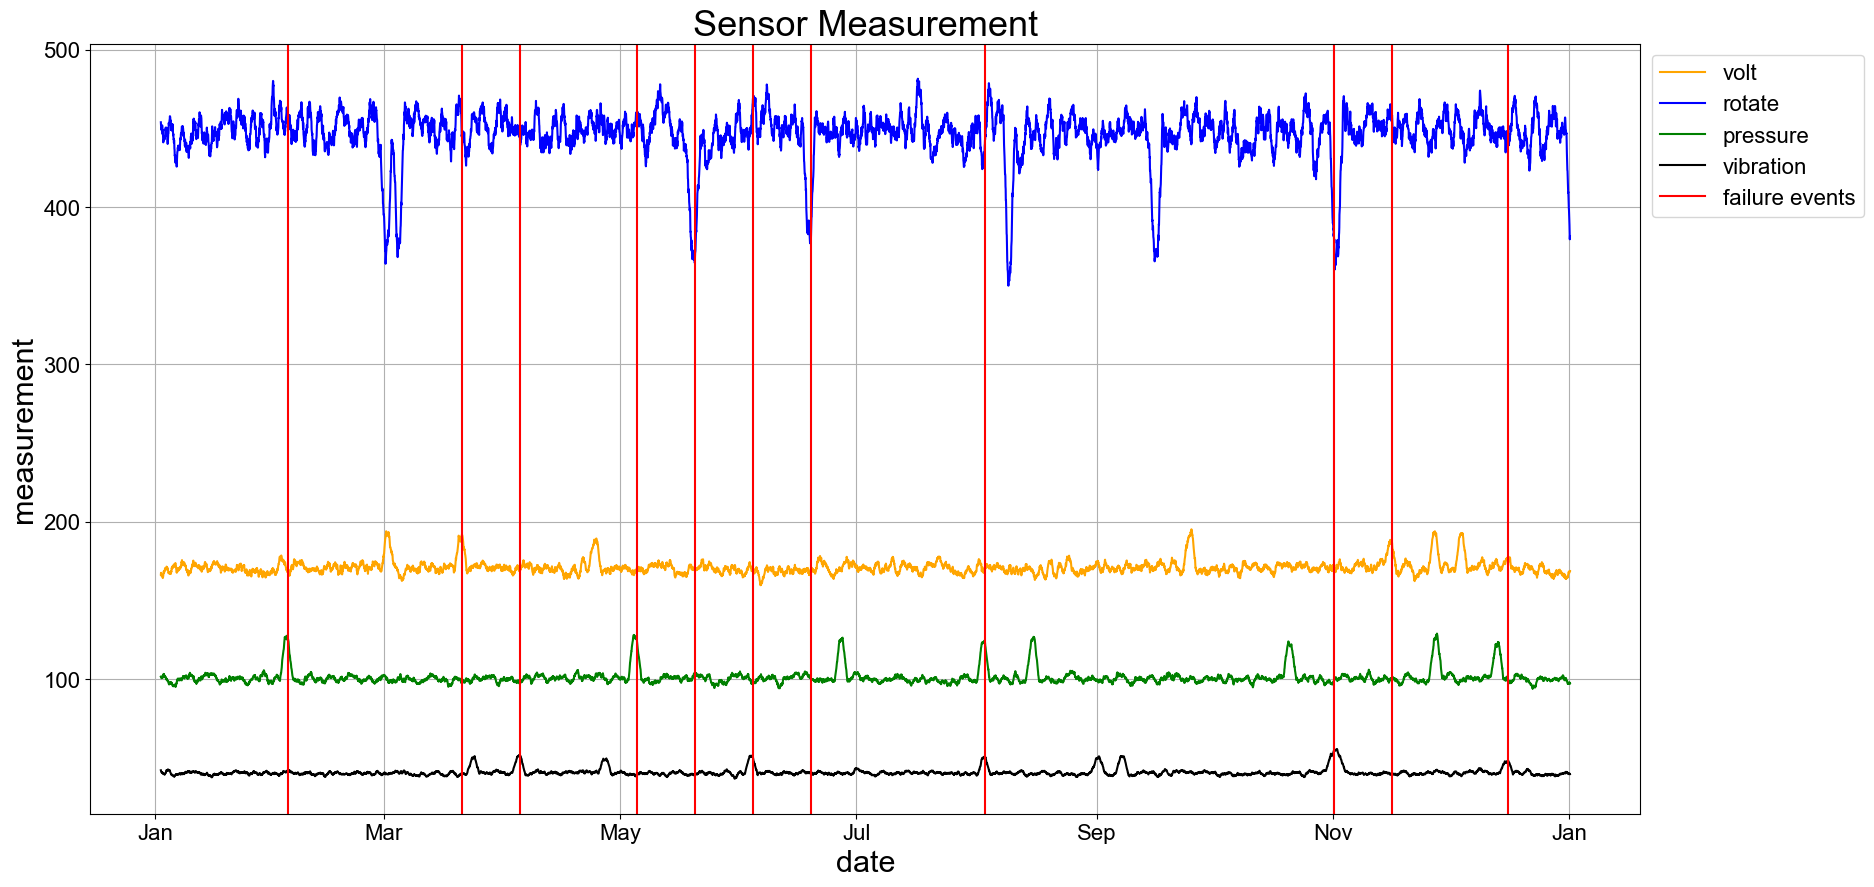

In [23]:
# window_size and step_size are set as the same
window_size = 30
slide_mean_data = sliding_mean(sen_data, window_size, 1)
plot_diagnostic_data(slide_mean_data, fail_dt, None)

In [24]:
# Split the training set and test set, label the data
train_data,test_data,true_state = train_test_split(sen_data,fail_dt,'2015-06-01',30)

normal     3584
failure       5
Name: state, dtype: int64


In [25]:
from sklearn import svm

# Instantiate and fit the model
svc = svm.SVC(C=0.5, kernel='rbf', degree=3, gamma='auto', \
             coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, \
             class_weight='balanced', verbose=False, max_iter=-1, decision_function_shape='ovr', \
             random_state=None)
svc.fit(train_data[train_data.columns.difference(['datetime', 'state'])], train_data['state'])

# use model predict label for test data
svc_predict = svc.predict(test_data[test_data.columns.difference(['datetime', 'state'])])
svc_fail_dt = test_data[svc_predict=='failure']['datetime'].to_frame().reset_index() 



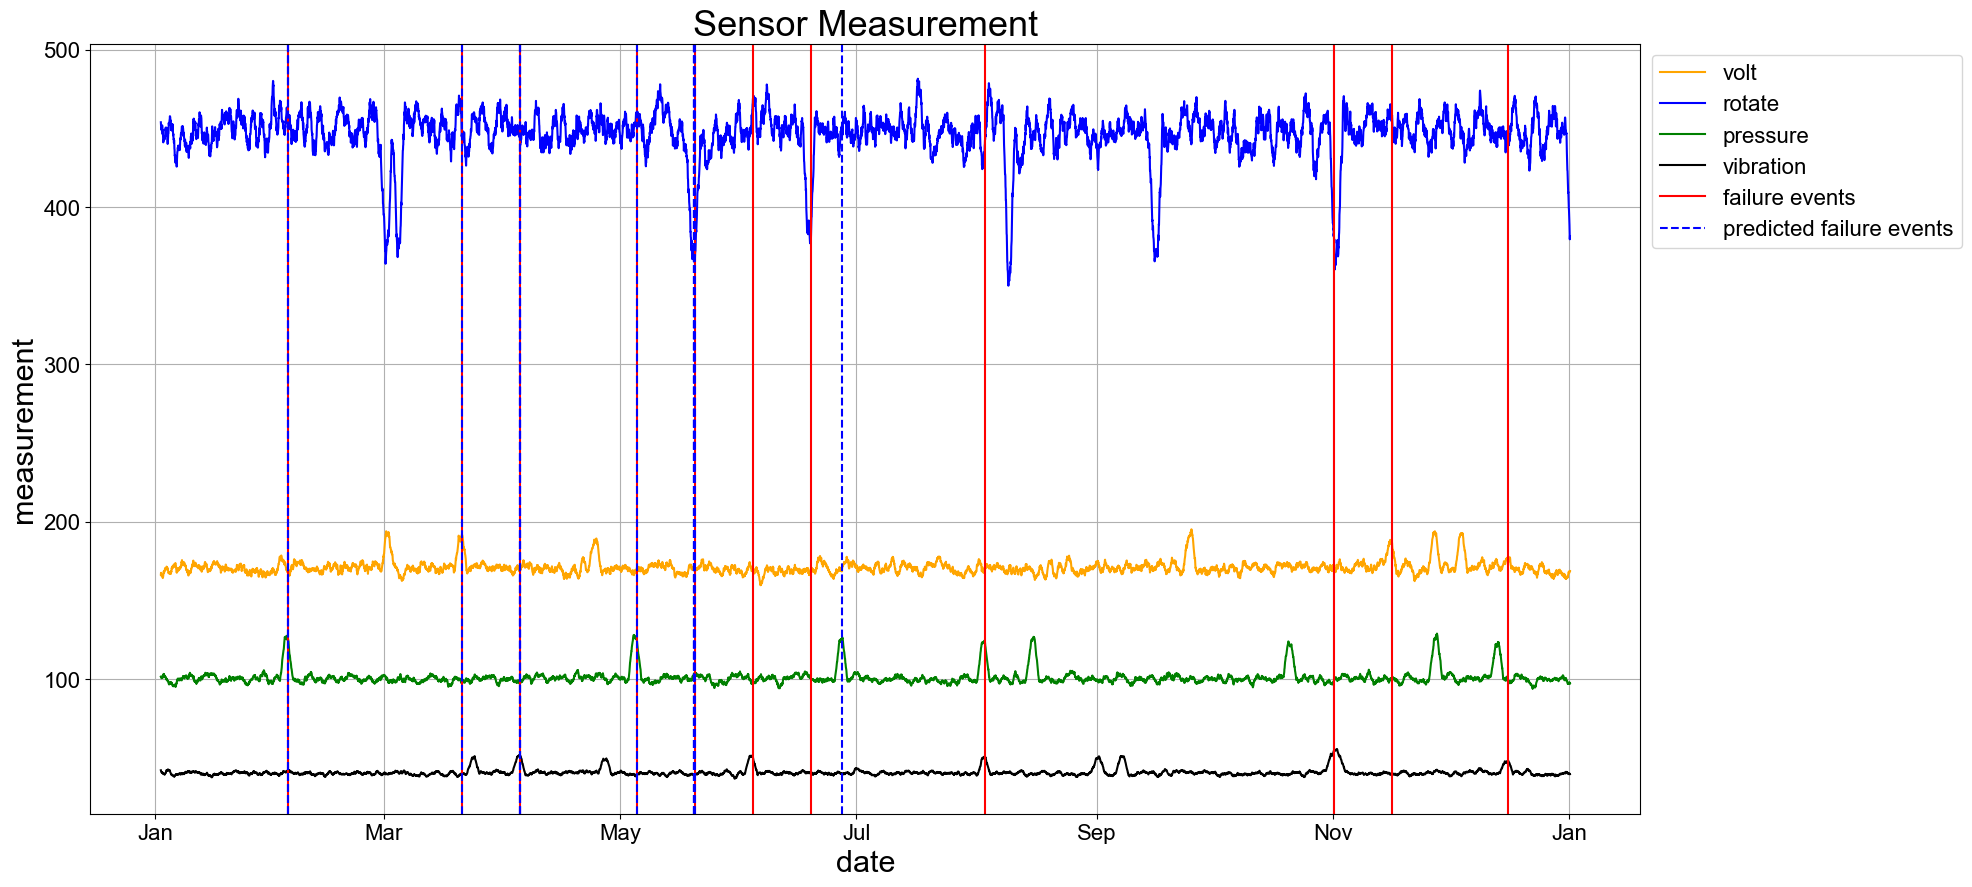

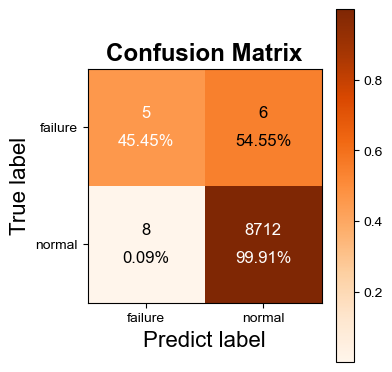

The accuracy of the model is 0.998
The GMean of the model is 0.674
The recall of the model is 0.455
The specificity of the model is 0.999
The precision of the model is 0.385
The F1 of the model is 0.417


In [26]:
# Show the diagnostic data graph with actual and predicted failures
plot_diagnostic_data(test_data, fail_dt, svc_fail_dt)
#print out the six classification metrics.
confusion_m(svc_predict, true_state)

### 9  Logistic Regression

Zhou Xiaolin A0259911X

#### The Logistic Regression performs worse than others since it uses the "logistic model" (sigmold function) to model the probability of a certain class. However, the decision boundary is a log-like curve, making it much suitable for linearly separable data.

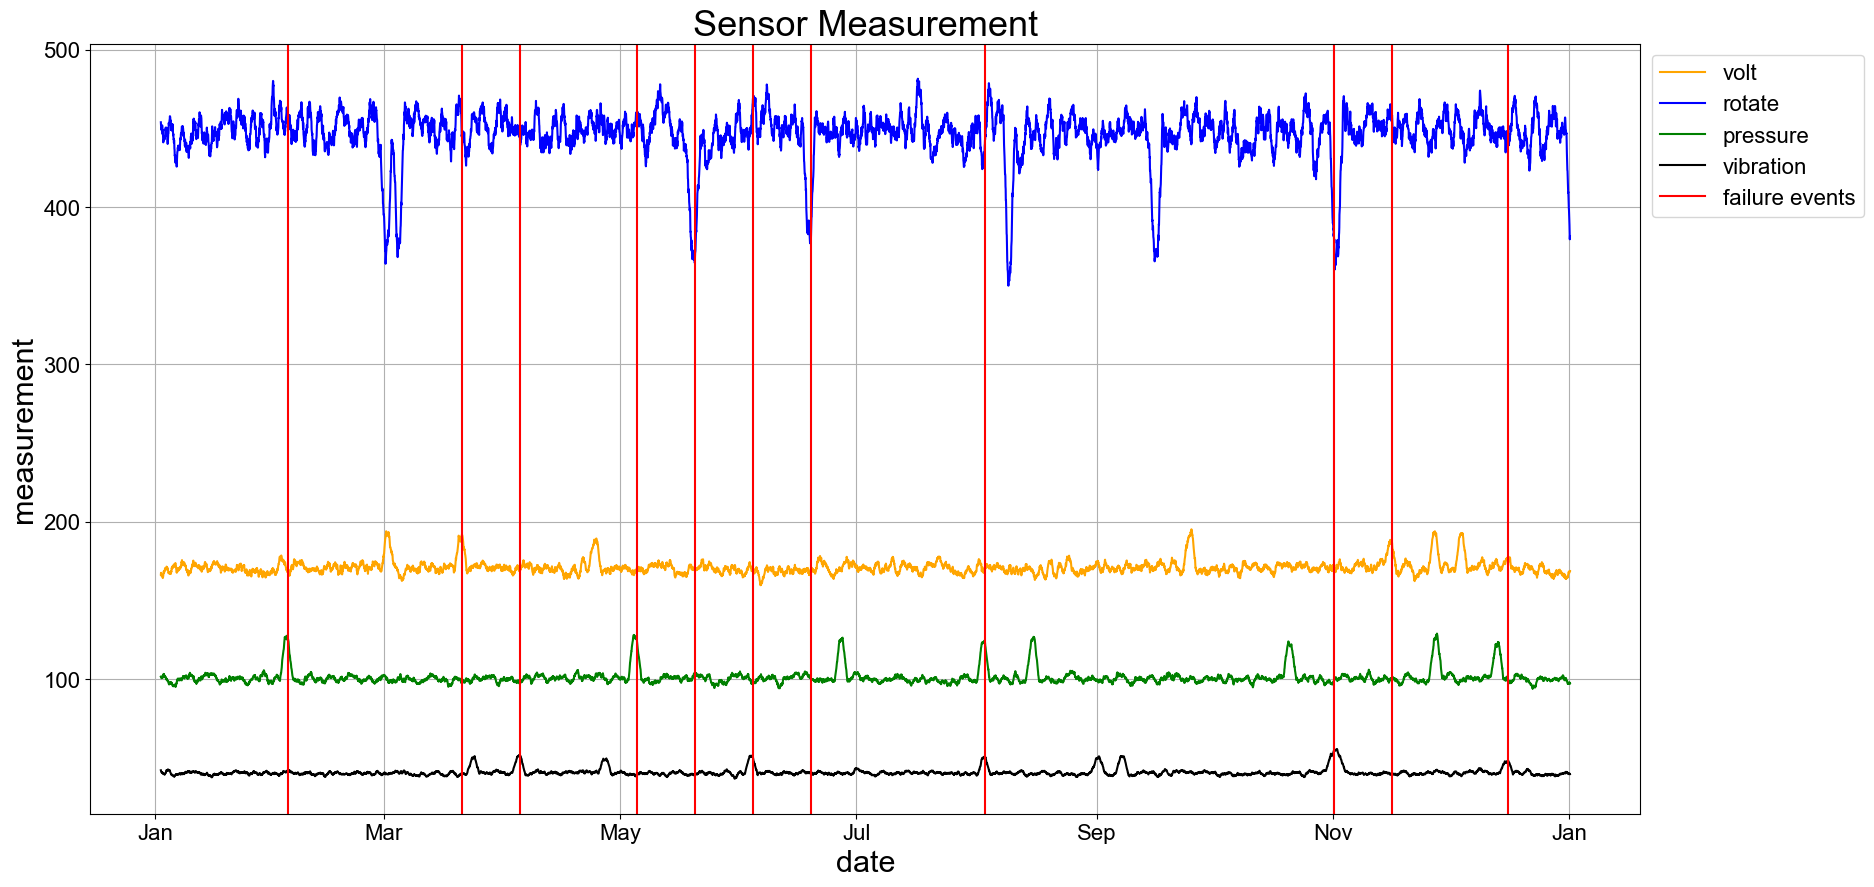

In [27]:
# window_size and step_size are set as the same
window_size = 30
slide_mean_data = sliding_mean(sen_data, window_size, 1)
plot_diagnostic_data(slide_mean_data, fail_dt, None)

In [28]:
# Split the training set and test set, label the data
train_data,test_data,true_state = train_test_split(sen_data,fail_dt,'2015-06-01',30)

normal     3584
failure       5
Name: state, dtype: int64


In [29]:
from sklearn.linear_model import LogisticRegression

# Instantiate and fit the model
lr = LogisticRegression(C=0.5, class_weight='balanced', dual=False,\
                        fit_intercept=True,intercept_scaling=50, \
                        max_iter=2000, multi_class='ovr', n_jobs=1,\
                        penalty='l1', random_state=5, solver='liblinear',\
                        tol=1e-6,verbose=1, warm_start=False)
clf = lr.fit(train_data[train_data.columns.difference(['datetime', 'state'])], train_data['state'])

# use model predict label for test data
lr_predict = clf.predict(test_data[test_data.columns.difference(['datetime', 'state'])])
lr_fail_dt = test_data[lr_predict=='failure']['datetime'].to_frame().reset_index() 


[LibLinear]iter   1  #CD cycles 16
iter   2  #CD cycles 6
iter   3  #CD cycles 18
iter   4  #CD cycles 10
iter   5  #CD cycles 12
iter   6  #CD cycles 2
iter   7  #CD cycles 1
iter   8  #CD cycles 64
iter   9  #CD cycles 43
iter  10  #CD cycles 17
iter  11  #CD cycles 49
iter  12  #CD cycles 14
iter  13  #CD cycles 24
iter  14  #CD cycles 26
iter  15  #CD cycles 14
iter  16  #CD cycles 8
iter  17  #CD cycles 4
iter  18  #CD cycles 2
iter  19  #CD cycles 6
iter  20  #CD cycles 12
iter  21  #CD cycles 12
iter  22  #CD cycles 5
iter  23  #CD cycles 8
iter  24  #CD cycles 6
iter  25  #CD cycles 8
iter  26  #CD cycles 6
iter  27  #CD cycles 7
iter  28  #CD cycles 4
iter  29  #CD cycles 9
iter  30  #CD cycles 12
iter  31  #CD cycles 1
iter  32  #CD cycles 48
iter  33  #CD cycles 923
iter  34  #CD cycles 92
iter  35  #CD cycles 226
iter  36  #CD cycles 55
iter  37  #CD cycles 16
iter  38  #CD cycles 40
iter  39  #CD cycles 141
iter  40  #CD cycles 32
iter  41  #CD cycles 9
iter  42  #CD cycle

iter 356  #CD cycles 55
iter 357  #CD cycles 274
iter 358  #CD cycles 39
iter 359  #CD cycles 315
iter 360  #CD cycles 55
iter 361  #CD cycles 75
iter 362  #CD cycles 33
iter 363  #CD cycles 177
iter 364  #CD cycles 83
iter 365  #CD cycles 88
iter 366  #CD cycles 21
iter 367  #CD cycles 142
iter 368  #CD cycles 81
iter 369  #CD cycles 34
iter 370  #CD cycles 29
iter 371  #CD cycles 45
iter 372  #CD cycles 187
iter 373  #CD cycles 56
iter 374  #CD cycles 59
iter 375  #CD cycles 66
iter 376  #CD cycles 57
iter 377  #CD cycles 67
iter 378  #CD cycles 16
iter 379  #CD cycles 13
iter 380  #CD cycles 9
iter 381  #CD cycles 74
iter 382  #CD cycles 22
iter 383  #CD cycles 39
iter 384  #CD cycles 2
iter 385  #CD cycles 31
iter 386  #CD cycles 16
iter 387  #CD cycles 134
iter 388  #CD cycles 27
iter 389  #CD cycles 36
iter 390  #CD cycles 137
iter 391  #CD cycles 67
iter 392  #CD cycles 64
iter 393  #CD cycles 32
iter 394  #CD cycles 40
iter 395  #CD cycles 9
iter 396  #CD cycles 21
iter 397  #C

iter 721  #CD cycles 27
iter 722  #CD cycles 5
iter 723  #CD cycles 2
iter 724  #CD cycles 65
iter 725  #CD cycles 17
iter 726  #CD cycles 71
iter 727  #CD cycles 57
iter 728  #CD cycles 12
iter 729  #CD cycles 12
iter 730  #CD cycles 3
iter 731  #CD cycles 1
iter 732  #CD cycles 1000
iter 733  #CD cycles 1000
iter 734  #CD cycles 1000
iter 735  #CD cycles 409
iter 736  #CD cycles 387
iter 737  #CD cycles 44
iter 738  #CD cycles 520
iter 739  #CD cycles 579
iter 740  #CD cycles 189
iter 741  #CD cycles 294
iter 742  #CD cycles 34
iter 743  #CD cycles 483
iter 744  #CD cycles 10
iter 745  #CD cycles 11
iter 746  #CD cycles 110
iter 747  #CD cycles 306
iter 748  #CD cycles 254
iter 749  #CD cycles 4
iter 750  #CD cycles 32
iter 751  #CD cycles 26
iter 752  #CD cycles 71
iter 753  #CD cycles 13
iter 754  #CD cycles 198
iter 755  #CD cycles 20
iter 756  #CD cycles 130
iter 757  #CD cycles 81
iter 758  #CD cycles 190
iter 759  #CD cycles 79
iter 760  #CD cycles 12
iter 761  #CD cycles 82
it

iter 1056  #CD cycles 177
iter 1057  #CD cycles 57
iter 1058  #CD cycles 125
iter 1059  #CD cycles 229
iter 1060  #CD cycles 51
iter 1061  #CD cycles 19
iter 1062  #CD cycles 61
iter 1063  #CD cycles 35
iter 1064  #CD cycles 30
iter 1065  #CD cycles 25
iter 1066  #CD cycles 11
iter 1067  #CD cycles 20
iter 1068  #CD cycles 24
iter 1069  #CD cycles 9
iter 1070  #CD cycles 20
iter 1071  #CD cycles 44
iter 1072  #CD cycles 63
iter 1073  #CD cycles 20
iter 1074  #CD cycles 132
iter 1075  #CD cycles 40
iter 1076  #CD cycles 75
iter 1077  #CD cycles 225
iter 1078  #CD cycles 41
iter 1079  #CD cycles 137
iter 1080  #CD cycles 40
iter 1081  #CD cycles 9
iter 1082  #CD cycles 22
iter 1083  #CD cycles 36
iter 1084  #CD cycles 11
iter 1085  #CD cycles 23
iter 1086  #CD cycles 42
iter 1087  #CD cycles 92
iter 1088  #CD cycles 138
iter 1089  #CD cycles 27
iter 1090  #CD cycles 21
iter 1091  #CD cycles 55
iter 1092  #CD cycles 62
iter 1093  #CD cycles 75
iter 1094  #CD cycles 13
iter 1095  #CD cycle

iter 1375  #CD cycles 1000
iter 1376  #CD cycles 190
iter 1377  #CD cycles 834
iter 1378  #CD cycles 89
iter 1379  #CD cycles 24
iter 1380  #CD cycles 90
iter 1381  #CD cycles 13
optimization finished, #iter = 1381
Objective value = 295.976785
#nonzeros/#features = 5/5


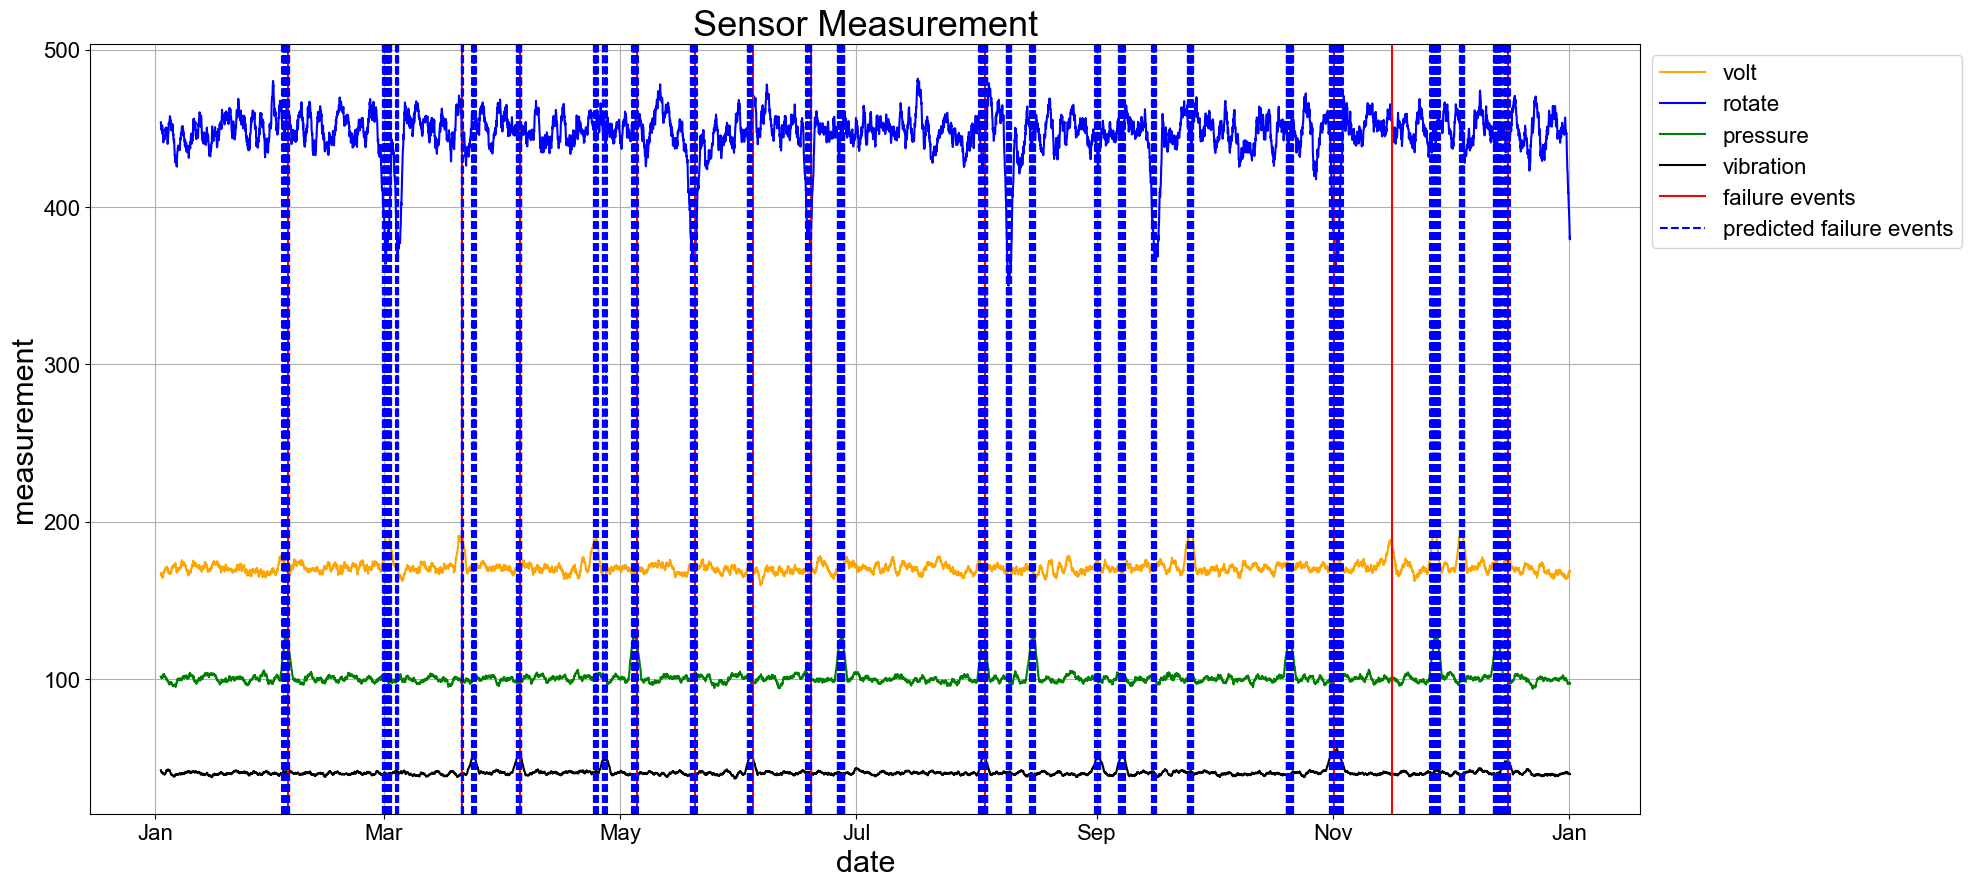

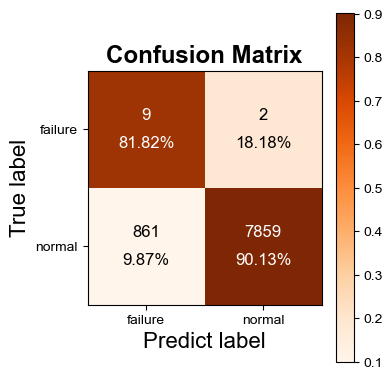

The accuracy of the model is 0.901
The GMean of the model is 0.859
The recall of the model is 0.818
The specificity of the model is 0.901
The precision of the model is 0.010
The F1 of the model is 0.020


In [30]:
# Show the diagnostic data graph with actual and predicted failures
plot_diagnostic_data(test_data, fail_dt, lr_fail_dt)
#print out the six classification metrics.
confusion_m(lr_predict, true_state)

### Tabulation of Results

Tabulate the 6 classification metrics (Accuracy, GMean, Recall, Specificity, Precision and F-score) in the form of a number between 0 and 1, with 3 decimal points, for all the failure prediction methods studied by the group.

The different methods should be shown as rows of the table in the order presented above, and the 6 classification metrics should be shown as columns of the table in the order shown above.

In [ ]:
# Write Code